# Logistic Regression

#### Imports

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Custom imports
import utils
import model_utils

# Stylesheet
plt.style.use('./styles.txt')
warnings.filterwarnings('ignore')

#### Index

1. [Introduction](#intro)<br>
2. [Data Loading](#dl)<br>
    2.1 [Preprocessing](#pp)<br>
3. [Modelling](#modelling)<br>
    3.1 [Downsampling](#downsampling)<br>
    3.2 [Upsampling](#upsampling)<br>
    3.3 [SMOTE](#smote)<br>
4. [Feature Selection](#fe)<br>
5. [Dimensionality Reduction with PCA](#dim_reduc)<br>
6. [Model Optimisation](#optimisation)<br>
    6.1 [Saving the model](#save)<br>
    6.2 [Loading the model](#load)<br>
7. [Remarks on Logistic Regression](#conc)

---
<a id='intro'></a>

# Introduction

Previously we tried to use regression models to predict the size of a wildfire on the features found within our data set. Unfortunately, these regression models performed poorly, even when simplifying the task to predict fires from the first four classes (A-D). Consequently, we decided that a model might perform better if given a classification task -  classifying the class that a fire will belong to - which has lead us to the current stage.

In this notebook we will be looking specifically at logistic regression, and optimising the model that we create through a number of methods. Before we begin, we need to load the data into our notebook.

---
<a id='dl'></a>

## Data Loading

In [2]:
df = utils.LoadDf()

# Check output
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,avg_tempmax,avg_temp,avg_humidity,...,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta
0,1992,1,0.10,A,43.325000,-101.018500,SD,5.257143,-2.928571,81.142857,...,0.000000,0.00,5.399184,3.5,47.062041,-1.8,1889.074286,-48.6,28.913469,-4.3
1,1992,1,1.00,B,33.058333,-79.979167,SC,13.700000,9.885714,81.428571,...,55.589796,-4.40,7.196327,0.1,5.575510,2.0,15648.559592,-14.9,19.071020,2.4
2,1992,2,0.25,A,40.775000,-74.854160,NJ,6.385714,1.585714,67.185714,...,9.546510,0.00,19.731020,4.0,34.516735,-10.6,16492.948163,-254.6,75.711429,-0.9
3,1992,3,1.91,B,31.018500,-83.297300,GA,14.457143,11.828571,78.957143,...,59.321224,-9.70,9.142041,-4.1,11.228571,0.2,16679.204898,223.6,21.585306,-8.4
4,1992,3,2.00,B,30.728900,-87.238100,FL,14.428571,10.985714,79.971429,...,0.213355,-1.32,10.262857,-7.9,27.382857,6.7,19587.093469,-24.8,13.107755,-2.7


In [3]:
utils.BasicEda(df, 'Wildfires', ['shape', 'columns', 'dtypes'])

WILDFIRES
---------

Rows: 29734    Columns: 34

FIRE_YEAR               int64
DISCOVERY_DOY           int64
FIRE_SIZE             float64
FIRE_SIZE_CLASS        object
LATITUDE              float64
LONGITUDE             float64
STATE                  object
avg_tempmax           float64
avg_temp              float64
avg_humidity          float64
avg_precip            float64
avg_dew               float64
avg_windspeed         float64
avg_winddir           float64
avg_pressure          float64
ch4                   float64
co2                   float64
n2o                   float64
tempmax_variance      float64
tempmax_delta         float64
temp_variance         float64
temp_delta            float64
humidity_variance     float64
humidity_delta        float64
precip_variance       float64
precip_delta          float64
dew_variance          float64
dew_delta             float64
windspeed_variance    float64
windspeed_delta       float64
winddir_variance      float64
winddir_delta        

<a id='pp'></a>
### Preprocessing

The data that we have loaded so far has not been preprocessed. Given the fact that a logistic regression is a linear model, we need to process the columns in the same way that we have previously. For categorical columns, this includes the binarisation of the state column. For numeric variables, we need to transform certain columns using a Box Cox transformation.

In [4]:
df = utils.BasicCategoricalPreprocessing(df)
df,_ = utils.BasicNumericPreprocessing(df)

In [5]:
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,avg_tempmax,avg_temp,avg_humidity,avg_precip,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1992,1,0.10,A,43.325000,-101.018500,5.257143,-2.928571,81.142857,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,1992,1,1.00,B,33.058333,-79.979167,13.700000,9.885714,81.428571,4.185714,...,0,0,0,0,0,0,0,0,0,0
2,1992,2,0.25,A,40.775000,-74.854160,6.385714,1.585714,67.185714,1.394286,...,0,0,0,0,0,0,0,0,0,0
3,1992,3,1.91,B,31.018500,-83.297300,14.457143,11.828571,78.957143,4.685714,...,0,0,0,0,0,0,0,0,0,0
4,1992,3,2.00,B,30.728900,-87.238100,14.428571,10.985714,79.971429,0.188571,...,0,0,0,0,0,0,0,0,0,0


---
<a id='modelling'></a>

## Modelling

As we saw from the initial model that we ran in a previous notebook, the accuracy of the model was severely affected by the distribution of the fires. As a classification model, the baseline model that we created initially was very poor at distinguishing between the different fire sizes, opting to classify most fires as coming from `FIRE_SIZE_CLASS` B, as this was the majority class. We therefore want to begin this modelling process by creating an even distribution in our samples. We can do this in a number of ways: we can upsample, downsample, and use methods such as SMOTE. To begin, we will downsample, selecting an equal amount of each class from the data we have available. It should be noted that this is the least popular resampling method, as we are reducing the number of observations. 

Before we build models using various resampling techniques, let us see how a baseline model performs on this data set.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = model_utils.GenerateXy(df)

X_train_transformed, X_test_transformed, y_train, y_test = model_utils.CreateTransformedTTS(X, y)

base_logit = LogisticRegression(max_iter=10000, random_state=1)
base_logit.fit(X_train_transformed, y_train)

print(f'The baseline model achieved {base_logit.score(X_test_transformed, y_test):.4f} accuracy.')

The baseline model was able to achieve 0.4290 accuracy


Let us see how this is distributed in a confusion matrix.

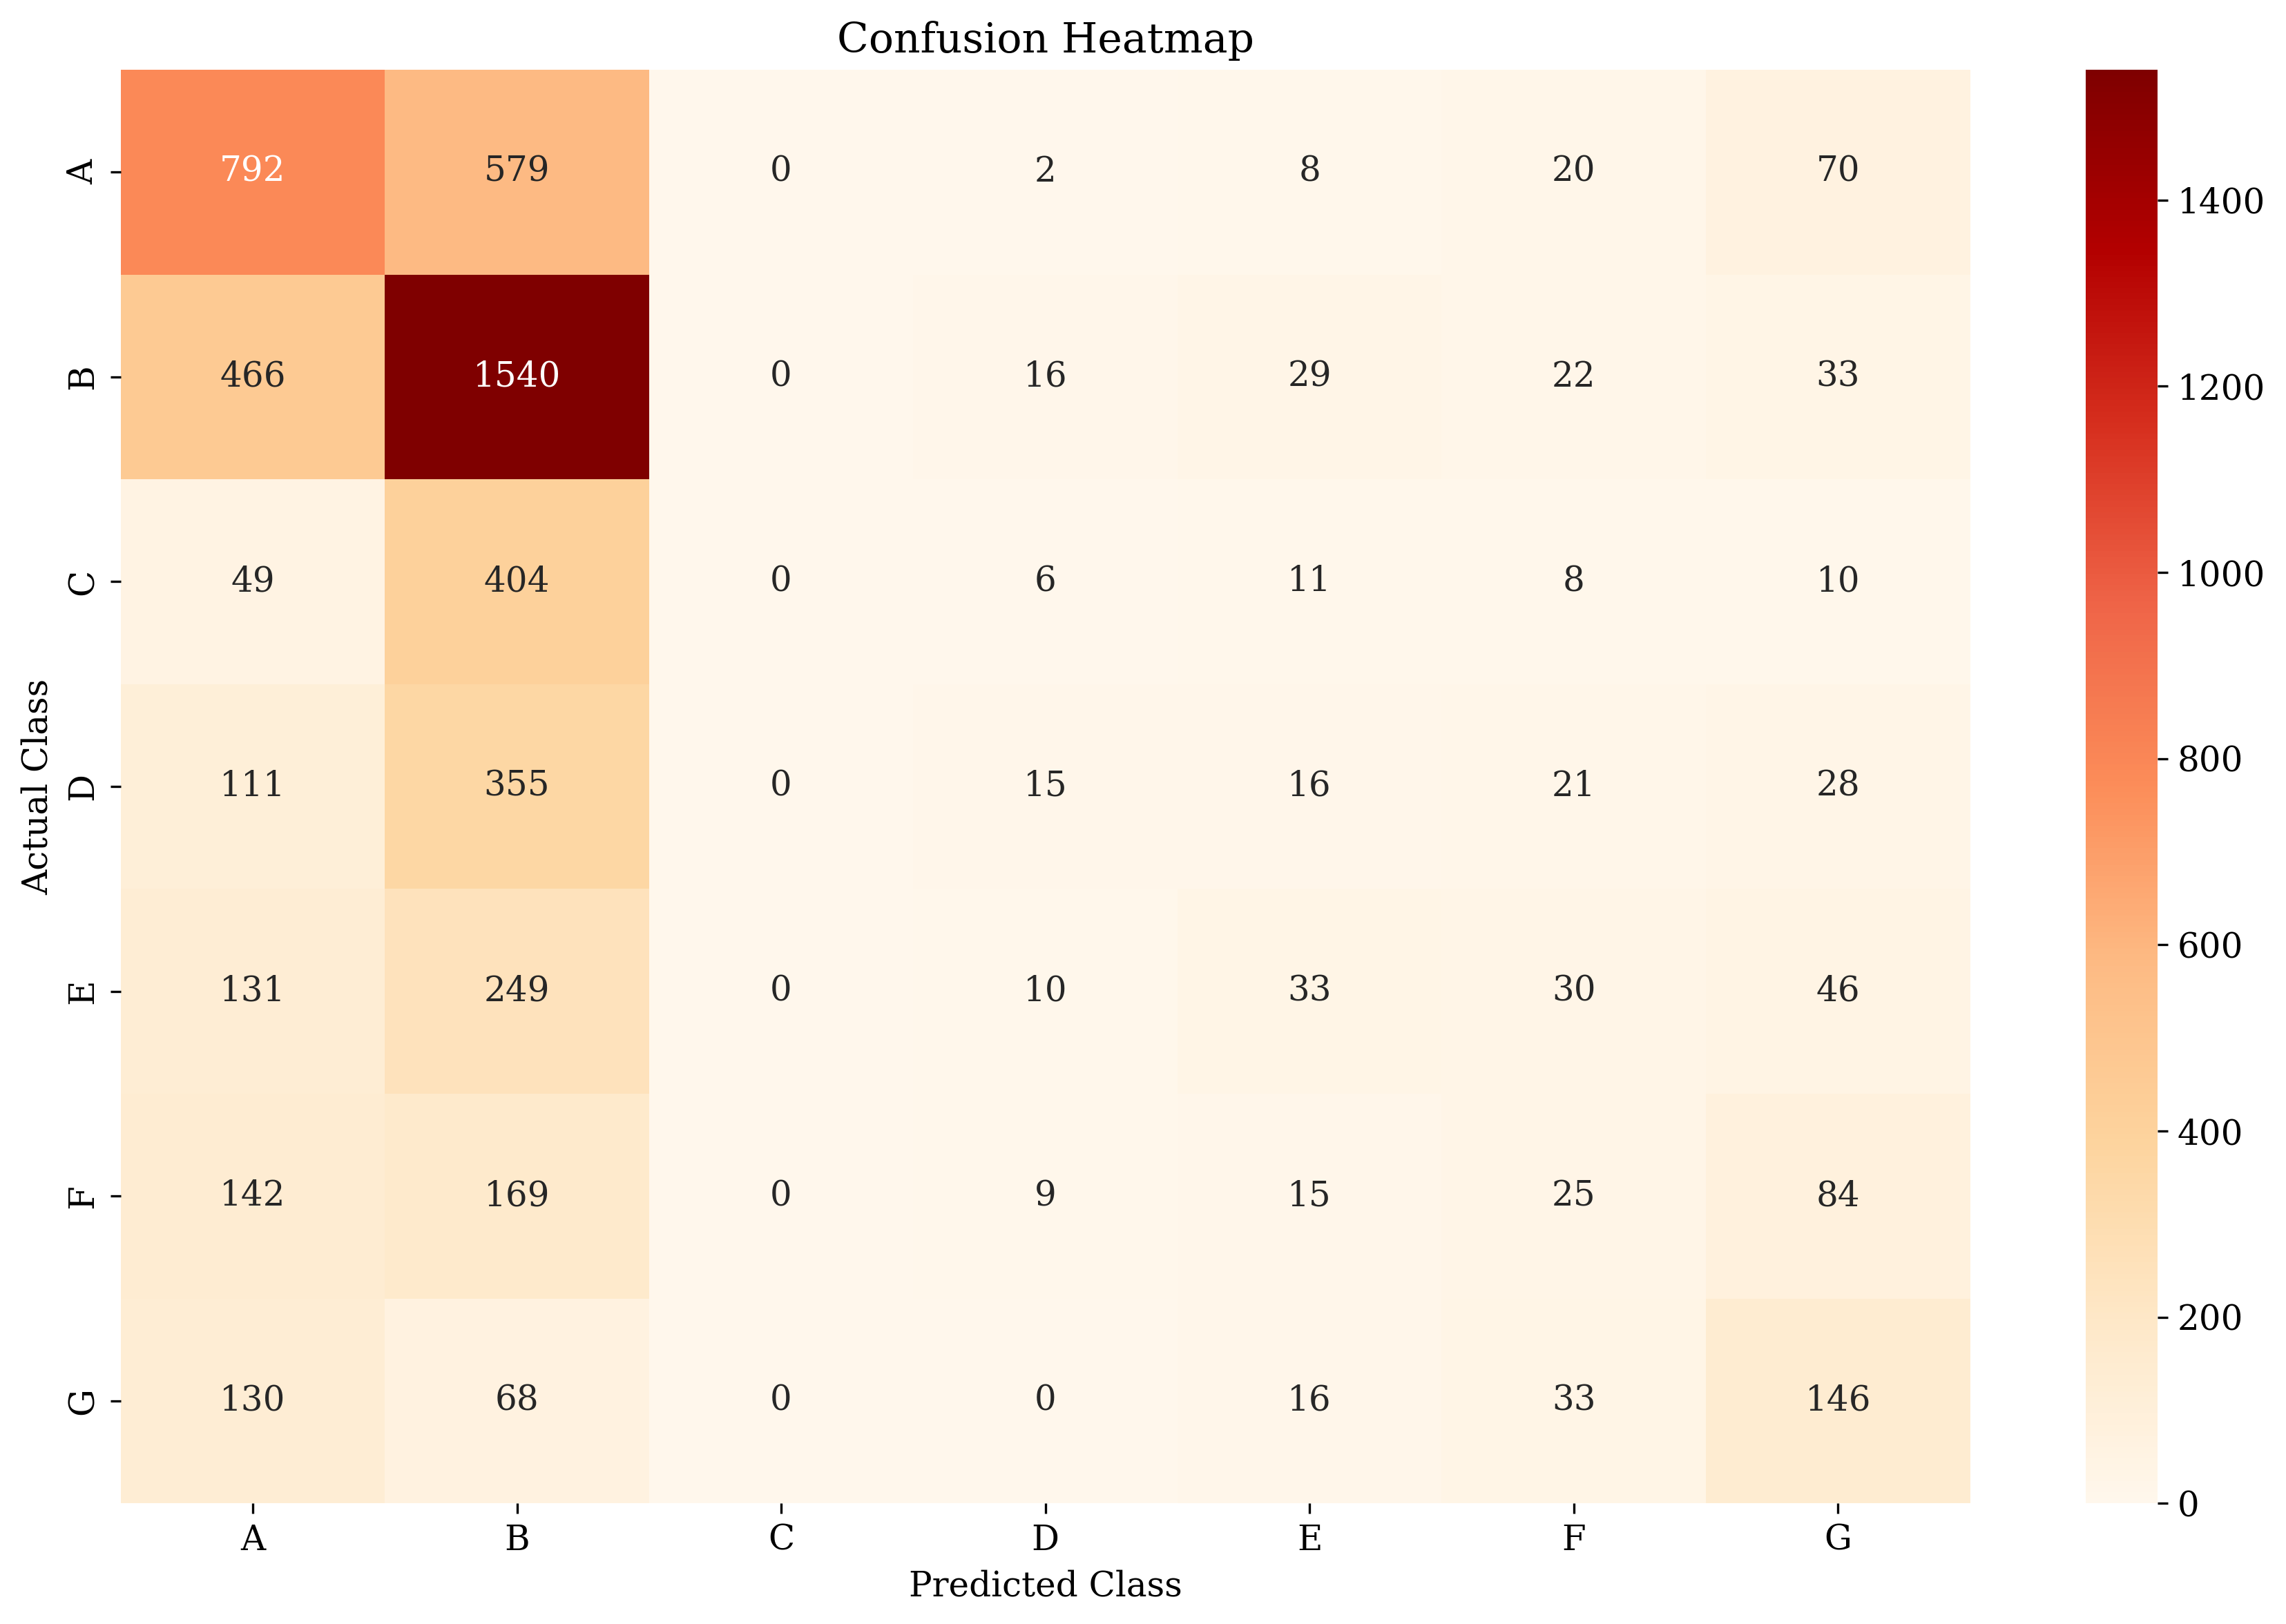

              precision    recall  f1-score   support

           A       0.43      0.54      0.48      1471
           B       0.46      0.73      0.56      2106
           C       0.00      0.00      0.00       488
           D       0.26      0.03      0.05       546
           E       0.26      0.07      0.11       499
           F       0.16      0.06      0.08       444
           G       0.35      0.37      0.36       393

    accuracy                           0.43      5947
   macro avg       0.27      0.26      0.23      5947
weighted avg       0.35      0.43      0.36      5947



In [34]:
model_utils.PlotConfusionMatrix(base_logit, X_test_transformed, y_test)

Before we analyse the output of the above code block we need to familiarise ourselves with the meaning of precision and recall. Precision and recall are two measures of the accuracy of a classifier. Precision is the number of correct positive results divided by the number of all positive results, and recall is the number of correct positive results divided by the number of positive results that should have been returned. The f1 score is the harmonic mean of the 2 values. Depending on the classification task, the importance of these measures will be gauged differently. In our case, it is important that we correctly identify a fire as we want to most effectively plan our response. Consequently, we may be more interested in ensuring that we have a high recall. 

While there are certain considerations for the relative importance of precision and recall, at the moment we should not preoccupy ourselves too much on these metrics as overall the model is performing pretty poorly. In general, we are trying to ensure that fires are being accurately identified as belonging to the correct class.

Although the accuracy of the model has decreased from the model we created with the more imbalanced data set (that model achieved an accuracy of 0.59), we see that the precision and recall for fires of category D and above have increased from what was previously a score of 0. As our primary target is to achieve better identification of larger wildfires, this increase in precision and recall is a step in the right direction, even though the model accuracy decreased as a consequence. 

<a id='downsampling'></a>

### Downsampling

Downsampling is a way of reducing the imbalance present in a data set and means training on a disproportionately low subset of the majority class examples. In our case, fire classes C and above are minority classes, whilst A and B form the majority. Our process of downsampling will therefore include finding the number of observations that belong to `FIRE_SIZE_CLASS` G (as this is the smallest class), and sampling that number of observations from each of the classes to generate an evenly balanced DataFrame.

To begin, let us see the counts for each class.

In [8]:
fire_size_class_df

,Count,Percentage of Total
A,7355,0.247360
B,10529,0.354106
C,2441,0.082095
D,2728,0.091747
E,2494,0.083877
F,2222,0.074729
G,1965,0.066086


`FIRE_SIZE_CLASS` G has 1965 observations. We will therefore take samples of size 1965 from each of the other classes, to get an even distribution.

In [9]:
# Create DataFrame
df_condensed = pd.DataFrame()

# Get the fire classes
fire_classes = df['FIRE_SIZE_CLASS'].unique()

# Get equal sample from each FIRE_SIZE_CLASS
for fire_class in fire_classes:
    tmp = df[df['FIRE_SIZE_CLASS'] == fire_class]
    df_condensed = pd.concat([df_condensed, tmp.sample(1965)])

In [10]:
df_condensed.shape

(13755, 85)

In [11]:
utils.count_percentage_df(df_condensed['FIRE_SIZE_CLASS'])

,Count,Percentage of Total
A,1965,0.142857
B,1965,0.142857
C,1965,0.142857
D,1965,0.142857
E,1965,0.142857
F,1965,0.142857
G,1965,0.142857


Having collected an even distribution of samples, we will now create a logistic regression. As with the linear regression model, we will use the same scaling methods as previously.

In [12]:
X = df_condensed.drop(['FIRE_SIZE','FIRE_SIZE_CLASS'], axis=1)
y = df_condensed['FIRE_SIZE_CLASS']

# Create column transformer
col_transformer = model_utils.CreateColumnTransformer(X)

# Create remainder and test
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [13]:
# Transform the train and validation set
X_train_transformed = col_transformer.fit_transform(X_train)
X_test_transformed = col_transformer.transform(X_test)

In [14]:
logreg = LogisticRegression(max_iter=10000, random_state=1)
logreg.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=10000, random_state=1)

In [15]:
logreg.score(X_train_transformed, y_train)

0.3370592511813886

In [16]:
X_test_transformed =  col_transformer.transform(X_test)
print(f'The downsampled model achieved {logreg.score(X_test_transformed, y_test):.4f} accuracy.')

0.3158851326790258

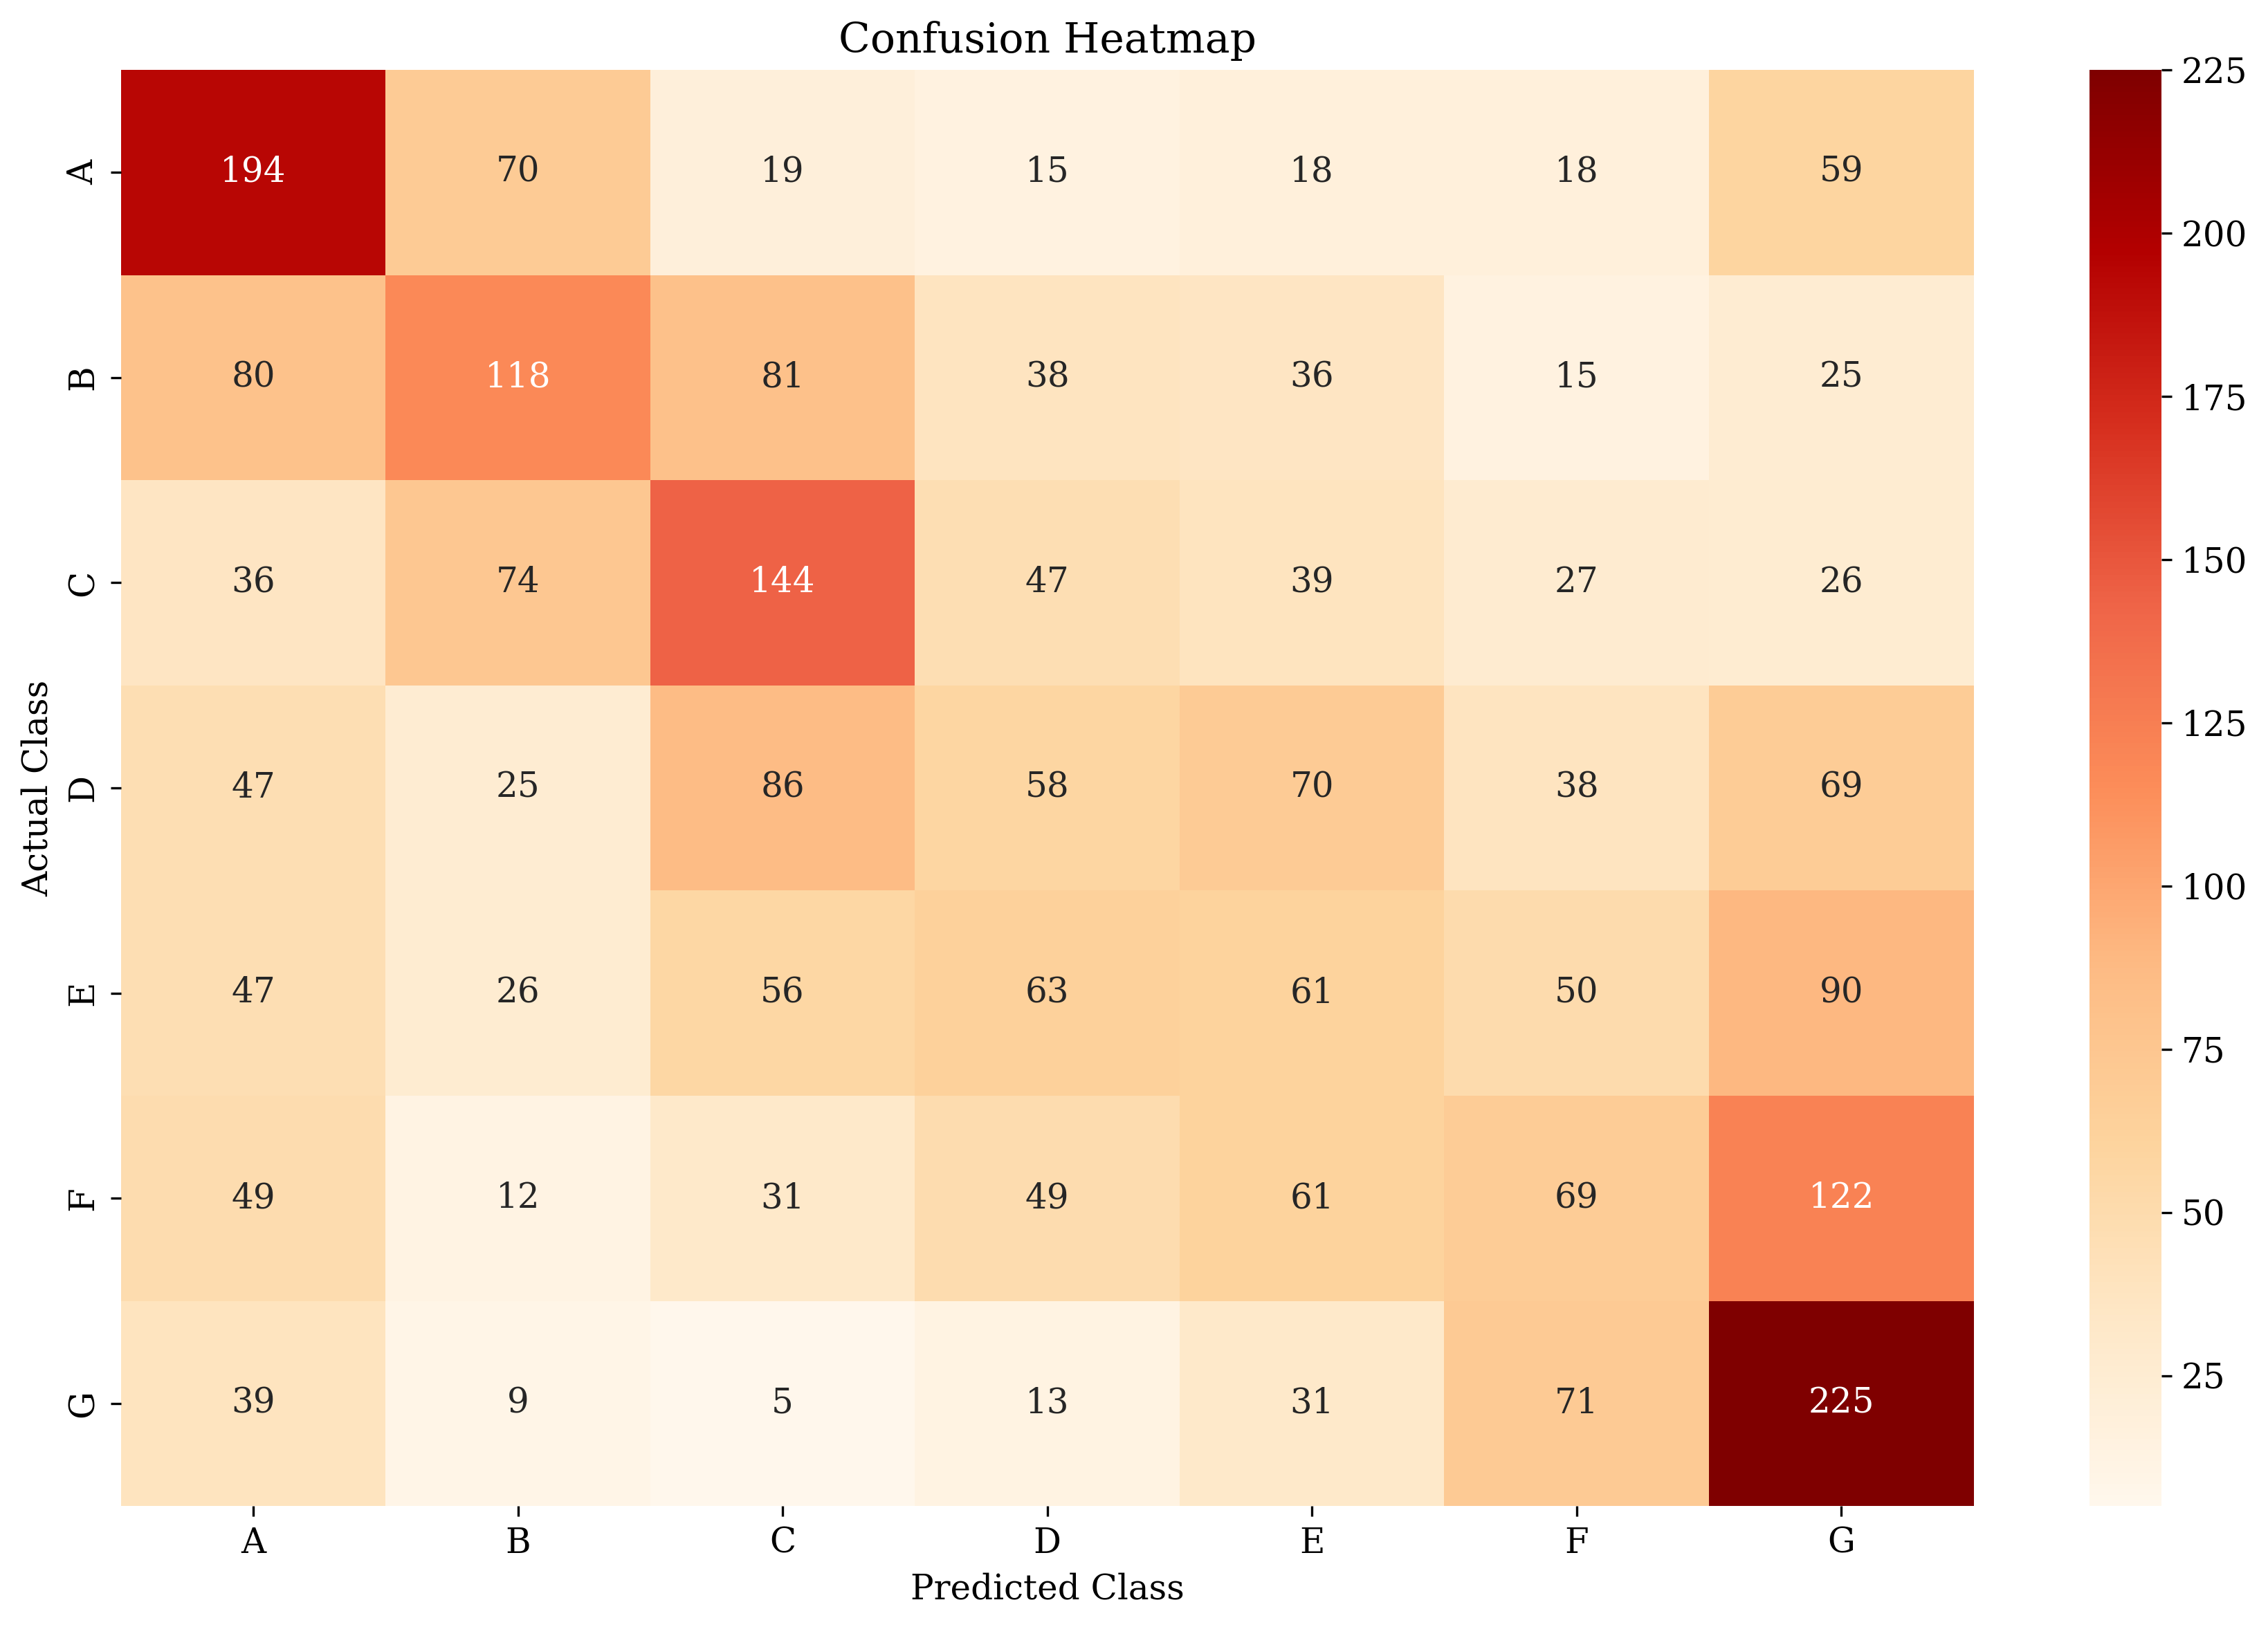

              precision    recall  f1-score   support

           A       0.39      0.49      0.44       393
           B       0.35      0.30      0.32       393
           C       0.34      0.37      0.35       393
           D       0.20      0.15      0.17       393
           E       0.19      0.16      0.17       393
           F       0.24      0.18      0.20       393
           G       0.37      0.57      0.45       393

    accuracy                           0.32      2751
   macro avg       0.30      0.32      0.30      2751
weighted avg       0.30      0.32      0.30      2751



In [17]:
model_utils.PlotConfusionMatrix(logreg, X_test_transformed, y_test)

There are a number of things that we can determine from this model. Given the even distribution of the classes, we see that the precision and recall classes C through G have increased from an initial value of 0 in our previous model. The baseline model that we created in that instance did have a better accuracy score, however this can be attributed to the imbalance in the data set. Interestingly, this model is good at predicting very large wildfires (class G), rather than any other fire. Let us take a look at the coefficients in this model.

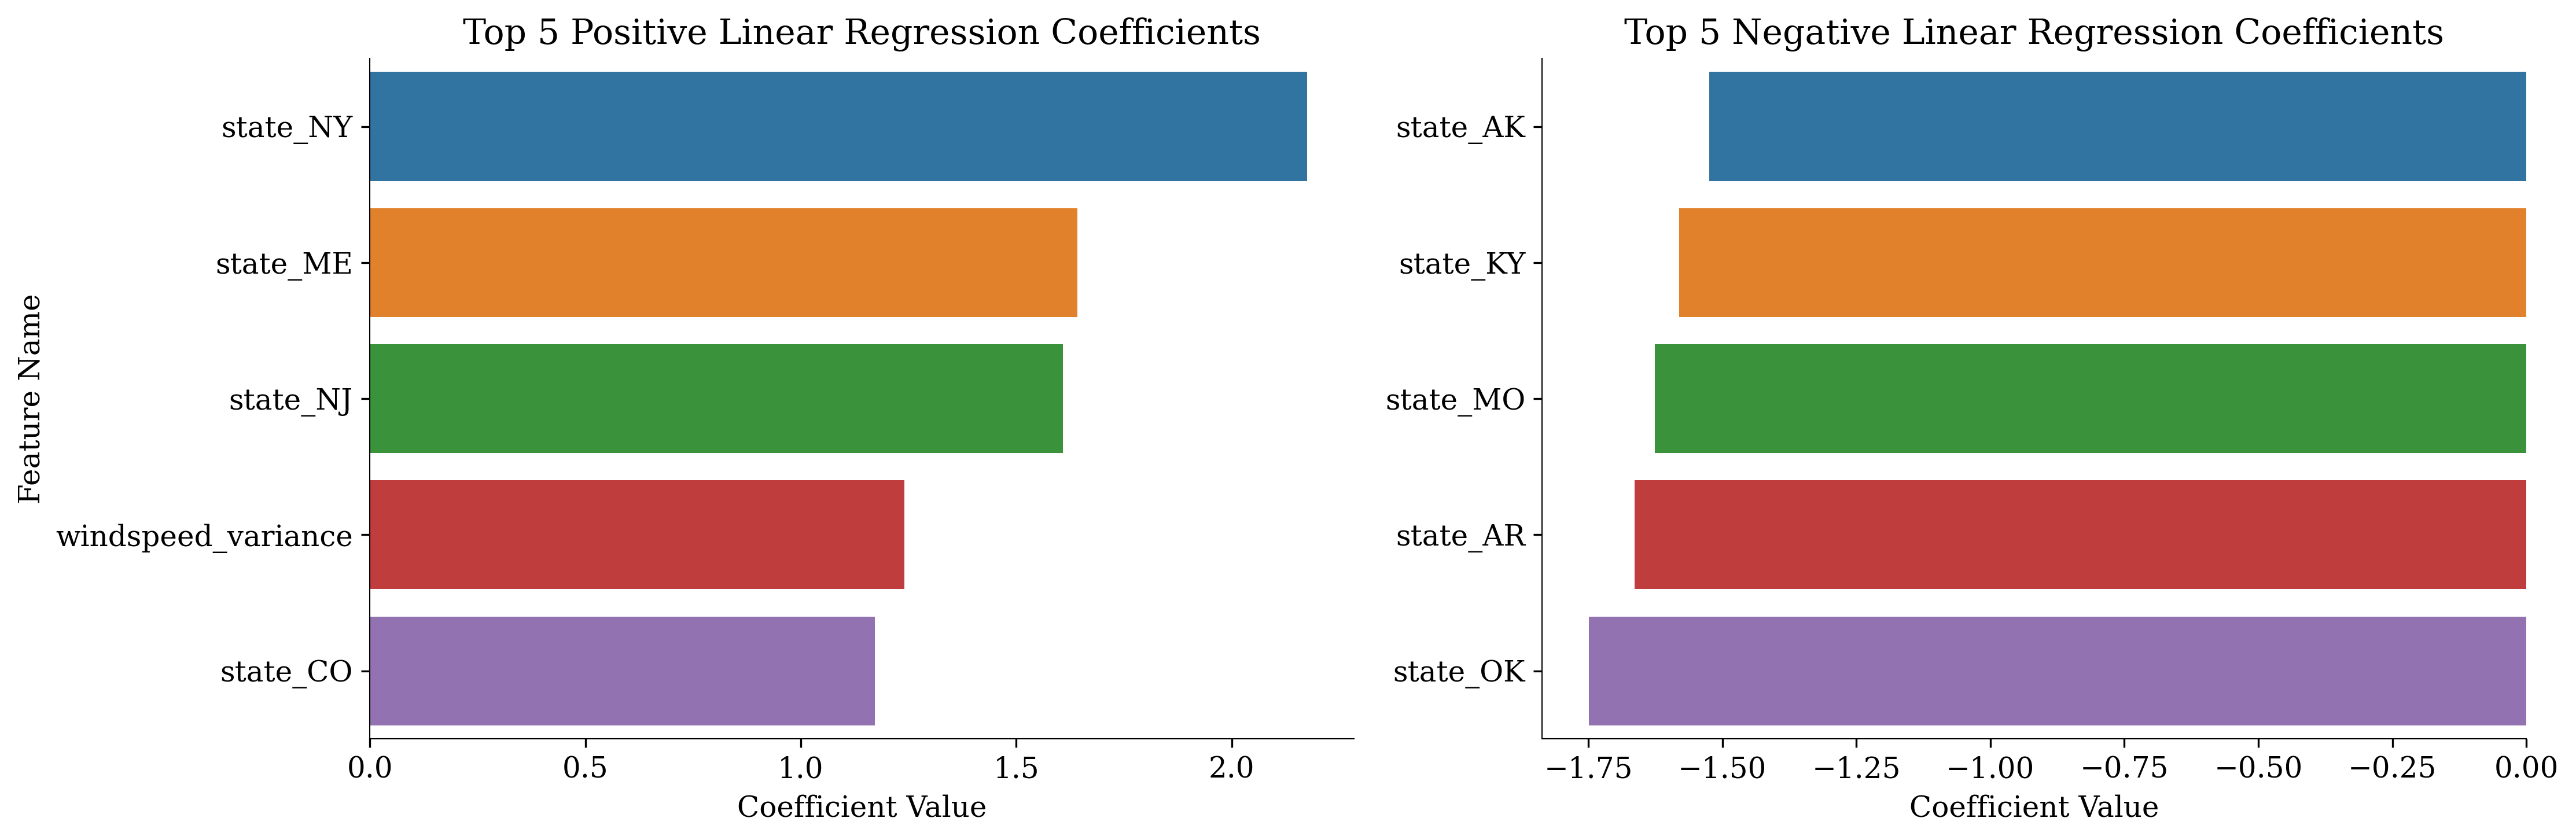

In [22]:
model_utils.PlotCoefficients(logreg, X)

Surprisingly, we see a number of coefficients that we had not seen previously, although we do see that the coefficient values have a far smaller variance in comparison to previous models.

<a id='upsampling'></a>
### Upsampling

As the name suggests, upsampling is the process of increasing the number of samples in a dataset. This is done by duplicating existing samples or by generating new samples through interpolation. By upsampling, we are hoping to increase the number of minority class observations and create a model that is better at classifying these.

In [23]:
# Upsampling using resample
from sklearn.utils import resample

# Get X and y variables
X, y = model_utils.GenerateXy(df)

# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

# Print Distribution of classes
utils.count_percentage_df(y_train).sort_index()

,Count,Percentage of Total
B,8409,0.353512
A,5851,0.245975
D,2172,0.091310
E,2023,0.085046
C,1990,0.083659
F,1791,0.075293
G,1551,0.065204


In [24]:
filter = ~((y_train == 'B') + (y_train =='A'))

X_upsampled, y_upsampled = resample(X_train[filter], 
                                    y_train[filter],
                                    n_samples=X_train[y_train=='B'].shape[0]*5,
                                    random_state=1)

utils.count_percentage_df(y_upsampled).sort_index()

,Count,Percentage of Total
D,9692,0.230515
E,8939,0.212606
C,8794,0.209157
F,7762,0.184612
G,6858,0.163111


We see that we have created a number of new observations from fire class D through G, which we can now append to the other observations.

In [26]:
# Combine upsample with original data
X_train_bal = np.vstack((X_train[(y_train == 'B') + (y_train =='A')], X_upsampled))
y_train_bal = np.hstack((y_train[(y_train == 'B') + (y_train =='A')], y_upsampled))

# Check updated distribution
utils.count_percentage_df(pd.Series(y_train_bal)).sort_index()

,Count,Percentage of Total
A,5851,0.103916
B,8409,0.149347
C,8794,0.156185
D,9692,0.172134
E,8939,0.158760
F,7762,0.137856
G,6858,0.121801


In [27]:
# Give the balanced train set feature names
X_train_bal = pd.DataFrame(X_train_bal, columns=X.columns)

In [28]:
# Transform train set
X_train_bal_transformed = col_transformer.fit_transform(X_train_bal)

In [29]:
# Build model
logreg_balanced = LogisticRegression(max_iter=10000, random_state=1)
logreg_balanced.fit(X_train_bal_transformed, y_train_bal)

LogisticRegression(max_iter=10000, random_state=1)

In [30]:
# Transform test set
X_test_transformed = col_transformer.transform(X_test)

# Print result
print(f'The upsampled model achieved {logreg_balanced.score(X_test_transformed, y_test):.4f} accuracy.')

0.06961493189843619

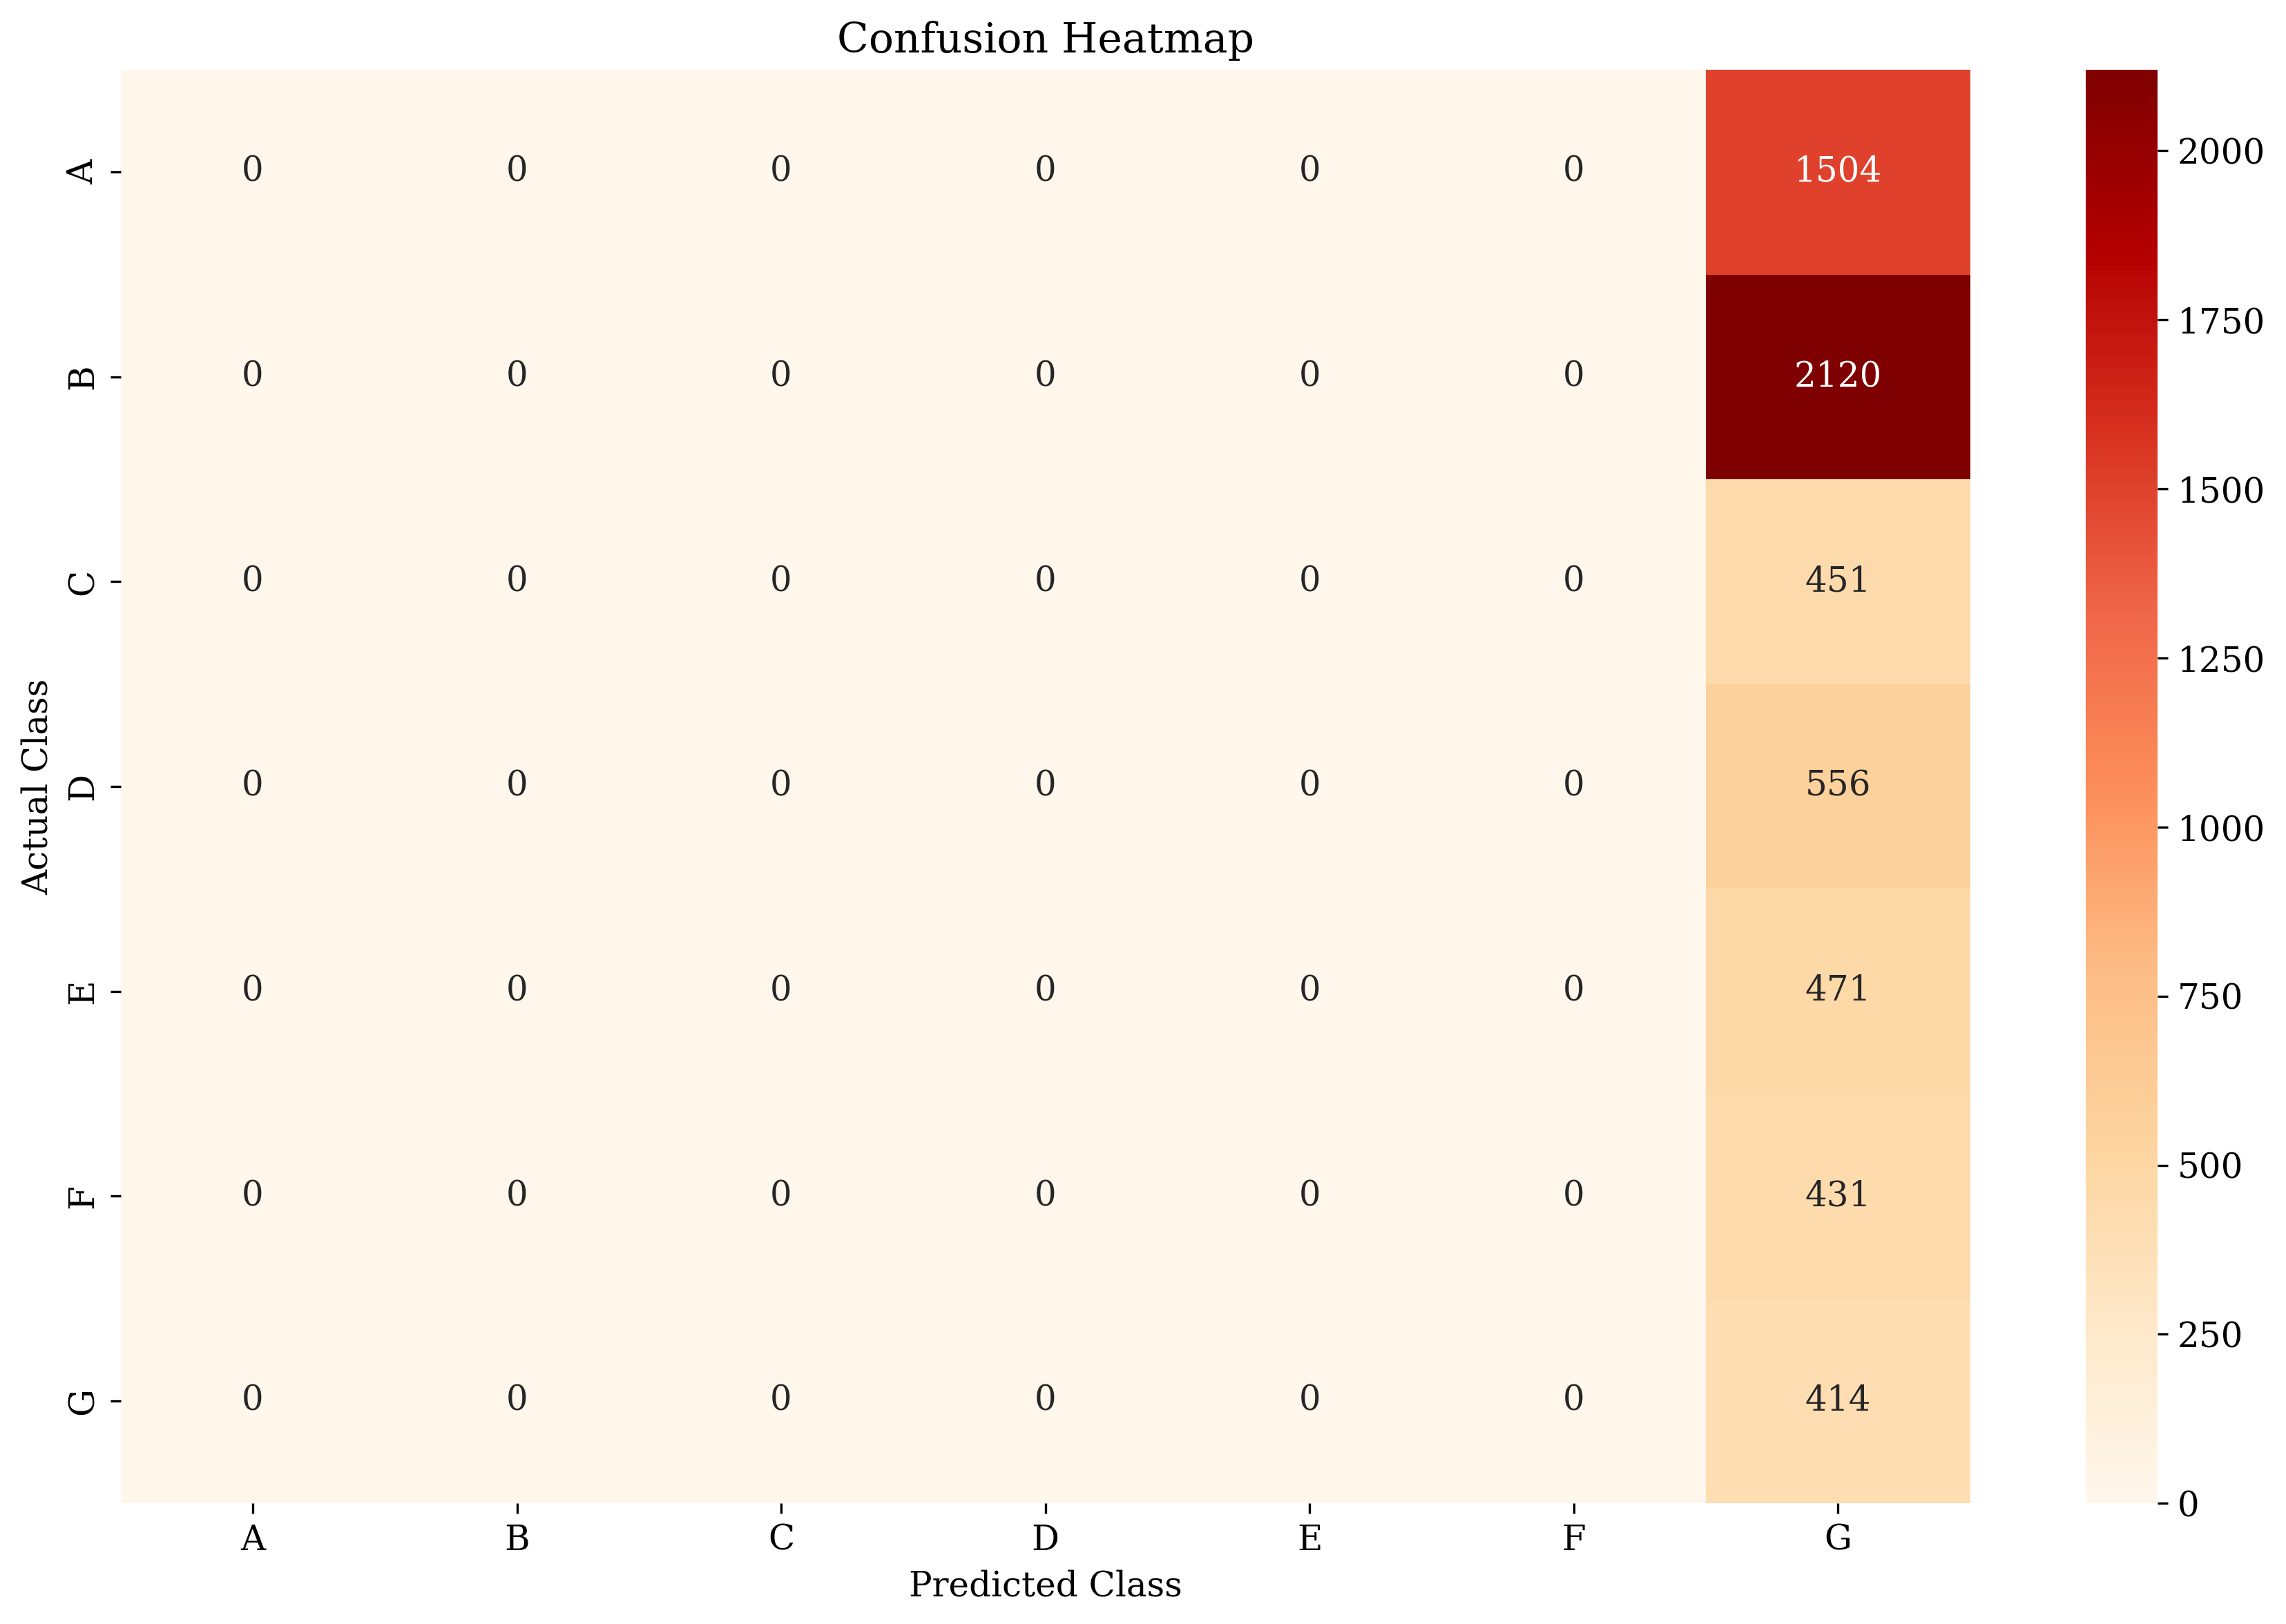

              precision    recall  f1-score   support

           A       0.00      0.00      0.00      1504
           B       0.00      0.00      0.00      2120
           C       0.00      0.00      0.00       451
           D       0.00      0.00      0.00       556
           E       0.00      0.00      0.00       471
           F       0.00      0.00      0.00       431
           G       0.07      1.00      0.13       414

    accuracy                           0.07      5947
   macro avg       0.01      0.14      0.02      5947
weighted avg       0.00      0.07      0.01      5947



In [31]:
model_utils.PlotConfusionMatrix(logreg_balanced, X_test_transformed, y_test)

As we can see from the accuracy score, as well as the confusion matrix, upsampling was unsuccessful in improving the model. Surprisingly, the model predicts that all the fires are of `FIRE_SIZE_CLASS` G, which is surprising considering that in previous models there was at least some distinction between the models. Perhaps we can improve upon this model by using Synthetic Minority Oversampling Technique (SMOTE) as an alternative. Let us see the coefficients that cause the behaviour of this model.

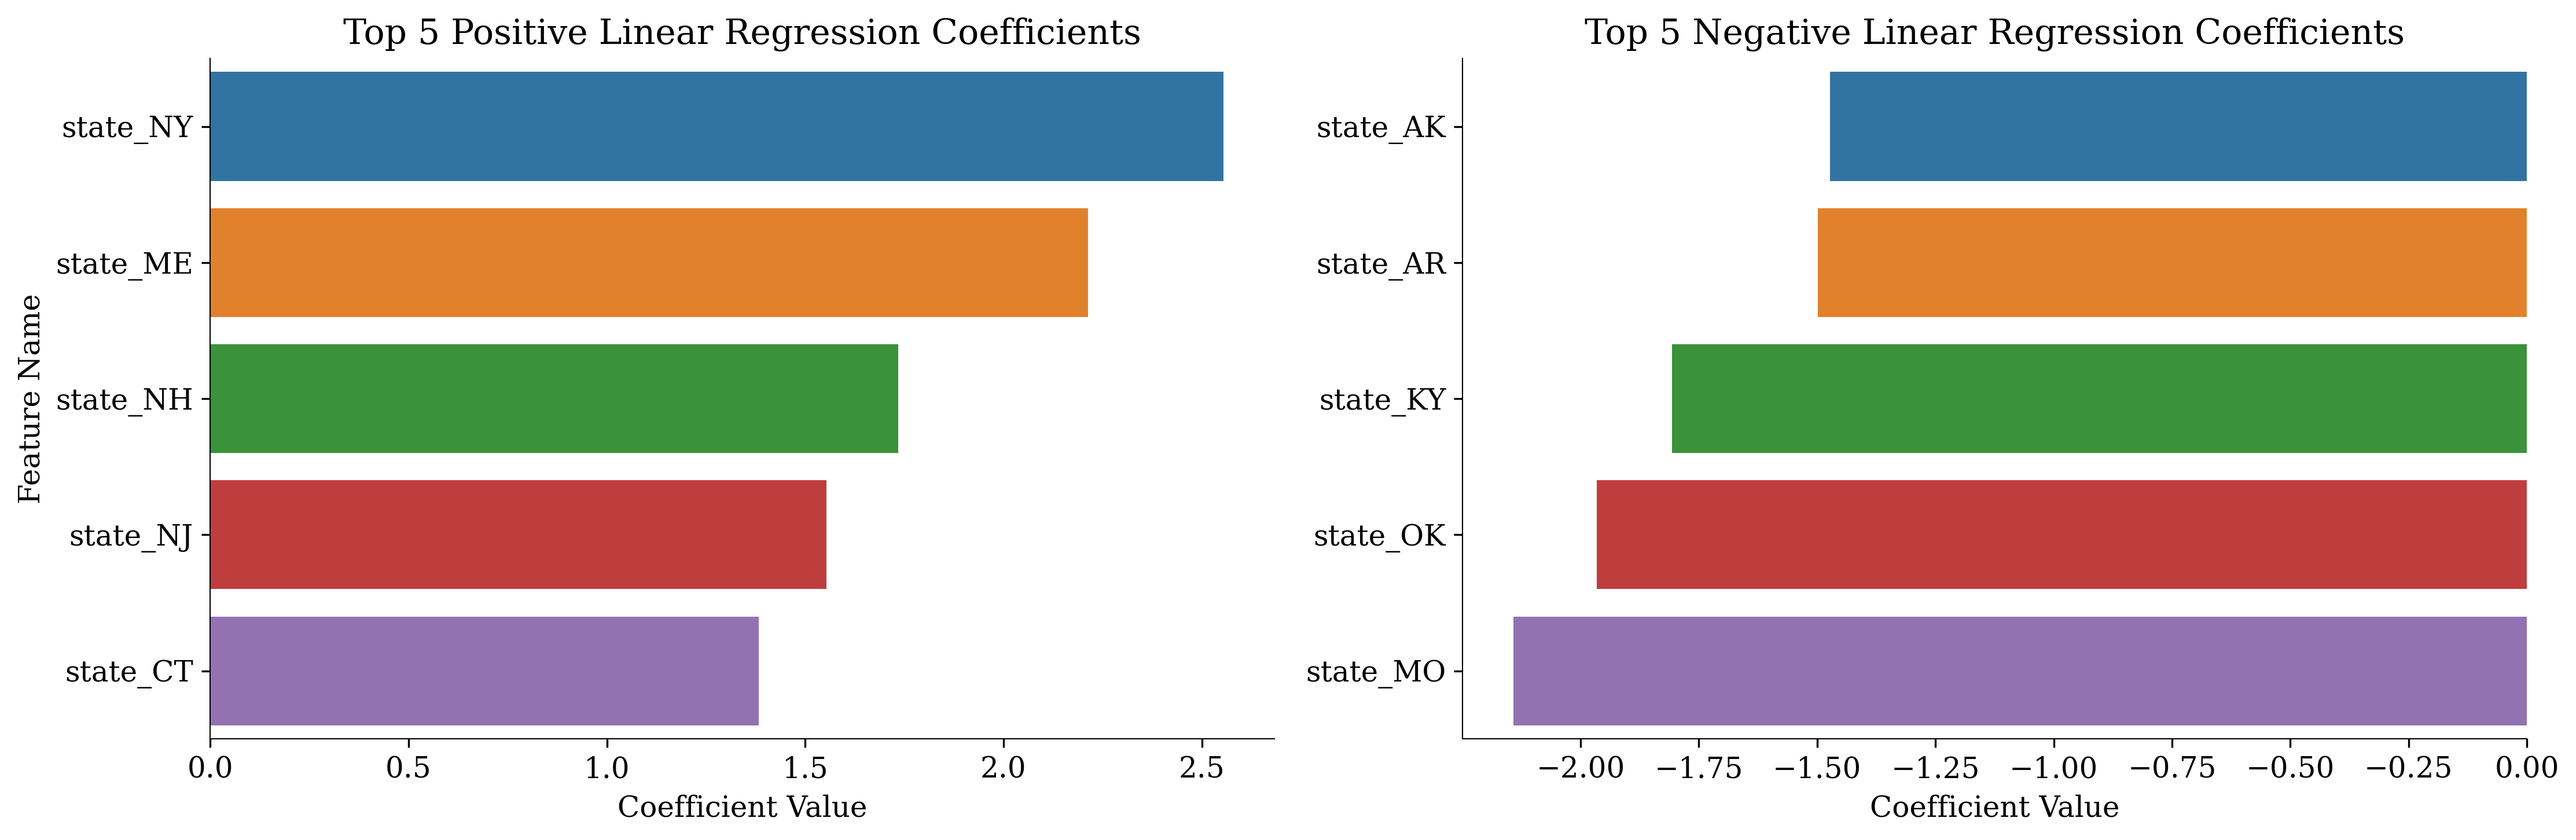

In [32]:
model_utils.PlotCoefficients(logreg_balanced, X)

<a id='smote'></a>

### SMOTE

While upsampling was able to increase the number of observations and balance the dataset, this method does not provide any additional information to the model. An improvement from simply duplicating examples from the minority classes is to synthesise new observations, which is what the Synthetic Minority Over-Sampling Technique (SMOTE) is able to achieve. 

But how does SMOTE work? The SMOTE algorithm works by selecting a minority class example at random and then producing a synthetic example that is similar to that example, but is distinct from the majority class. This is done by selecting one or more of the closest neighbors to the minority example and randomly selecting one of those neighbors to be the "donor" of the synthetic example. The new synthetic example is then created by taking a weighted sum of the minority example and the donor.

Now that we are familiar with how SMOTE works, we can implement it and build a model from the synthesised observations.

In [46]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

# instantiate SMOTE sampler, fit it to the training data, then resample the data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_train, y_train)

In [47]:
X_train_sm_transformed = pd.DataFrame(X_train_sm, columns=X.columns)
X_train_sm_transformed.shape

(58961, 83)

In [48]:
utils.count_percentage_df(y_train_sm)

,Count,Percentage of Total
B,8423,0.142857
A,8423,0.142857
D,8423,0.142857
E,8423,0.142857
G,8423,0.142857
C,8423,0.142857
F,8423,0.142857


This time, we have been able to generate more samples than previously, while not simply just reusing samples.

In [49]:
X_train_sm_transformed = col_transformer.transform(X_train_sm_transformed)

# Create base logistic regression
smote_logreg = LogisticRegression(max_iter=10000, random_state=1)
smote_logreg.fit(X_train_sm_transformed, y_train_sm)

LogisticRegression(max_iter=10000, random_state=1)

In [50]:
# Score the train set
smote_logreg.score(X_train_sm_transformed, y_train_sm)

0.3819982700429097

In [51]:
X_test_transformed = col_transformer.transform(X_test)
print(f'The model using SMOTE achieved {smote_logreg.score(X_test_transformed, y_test):.4f} accuracy')

0.4109635110139566

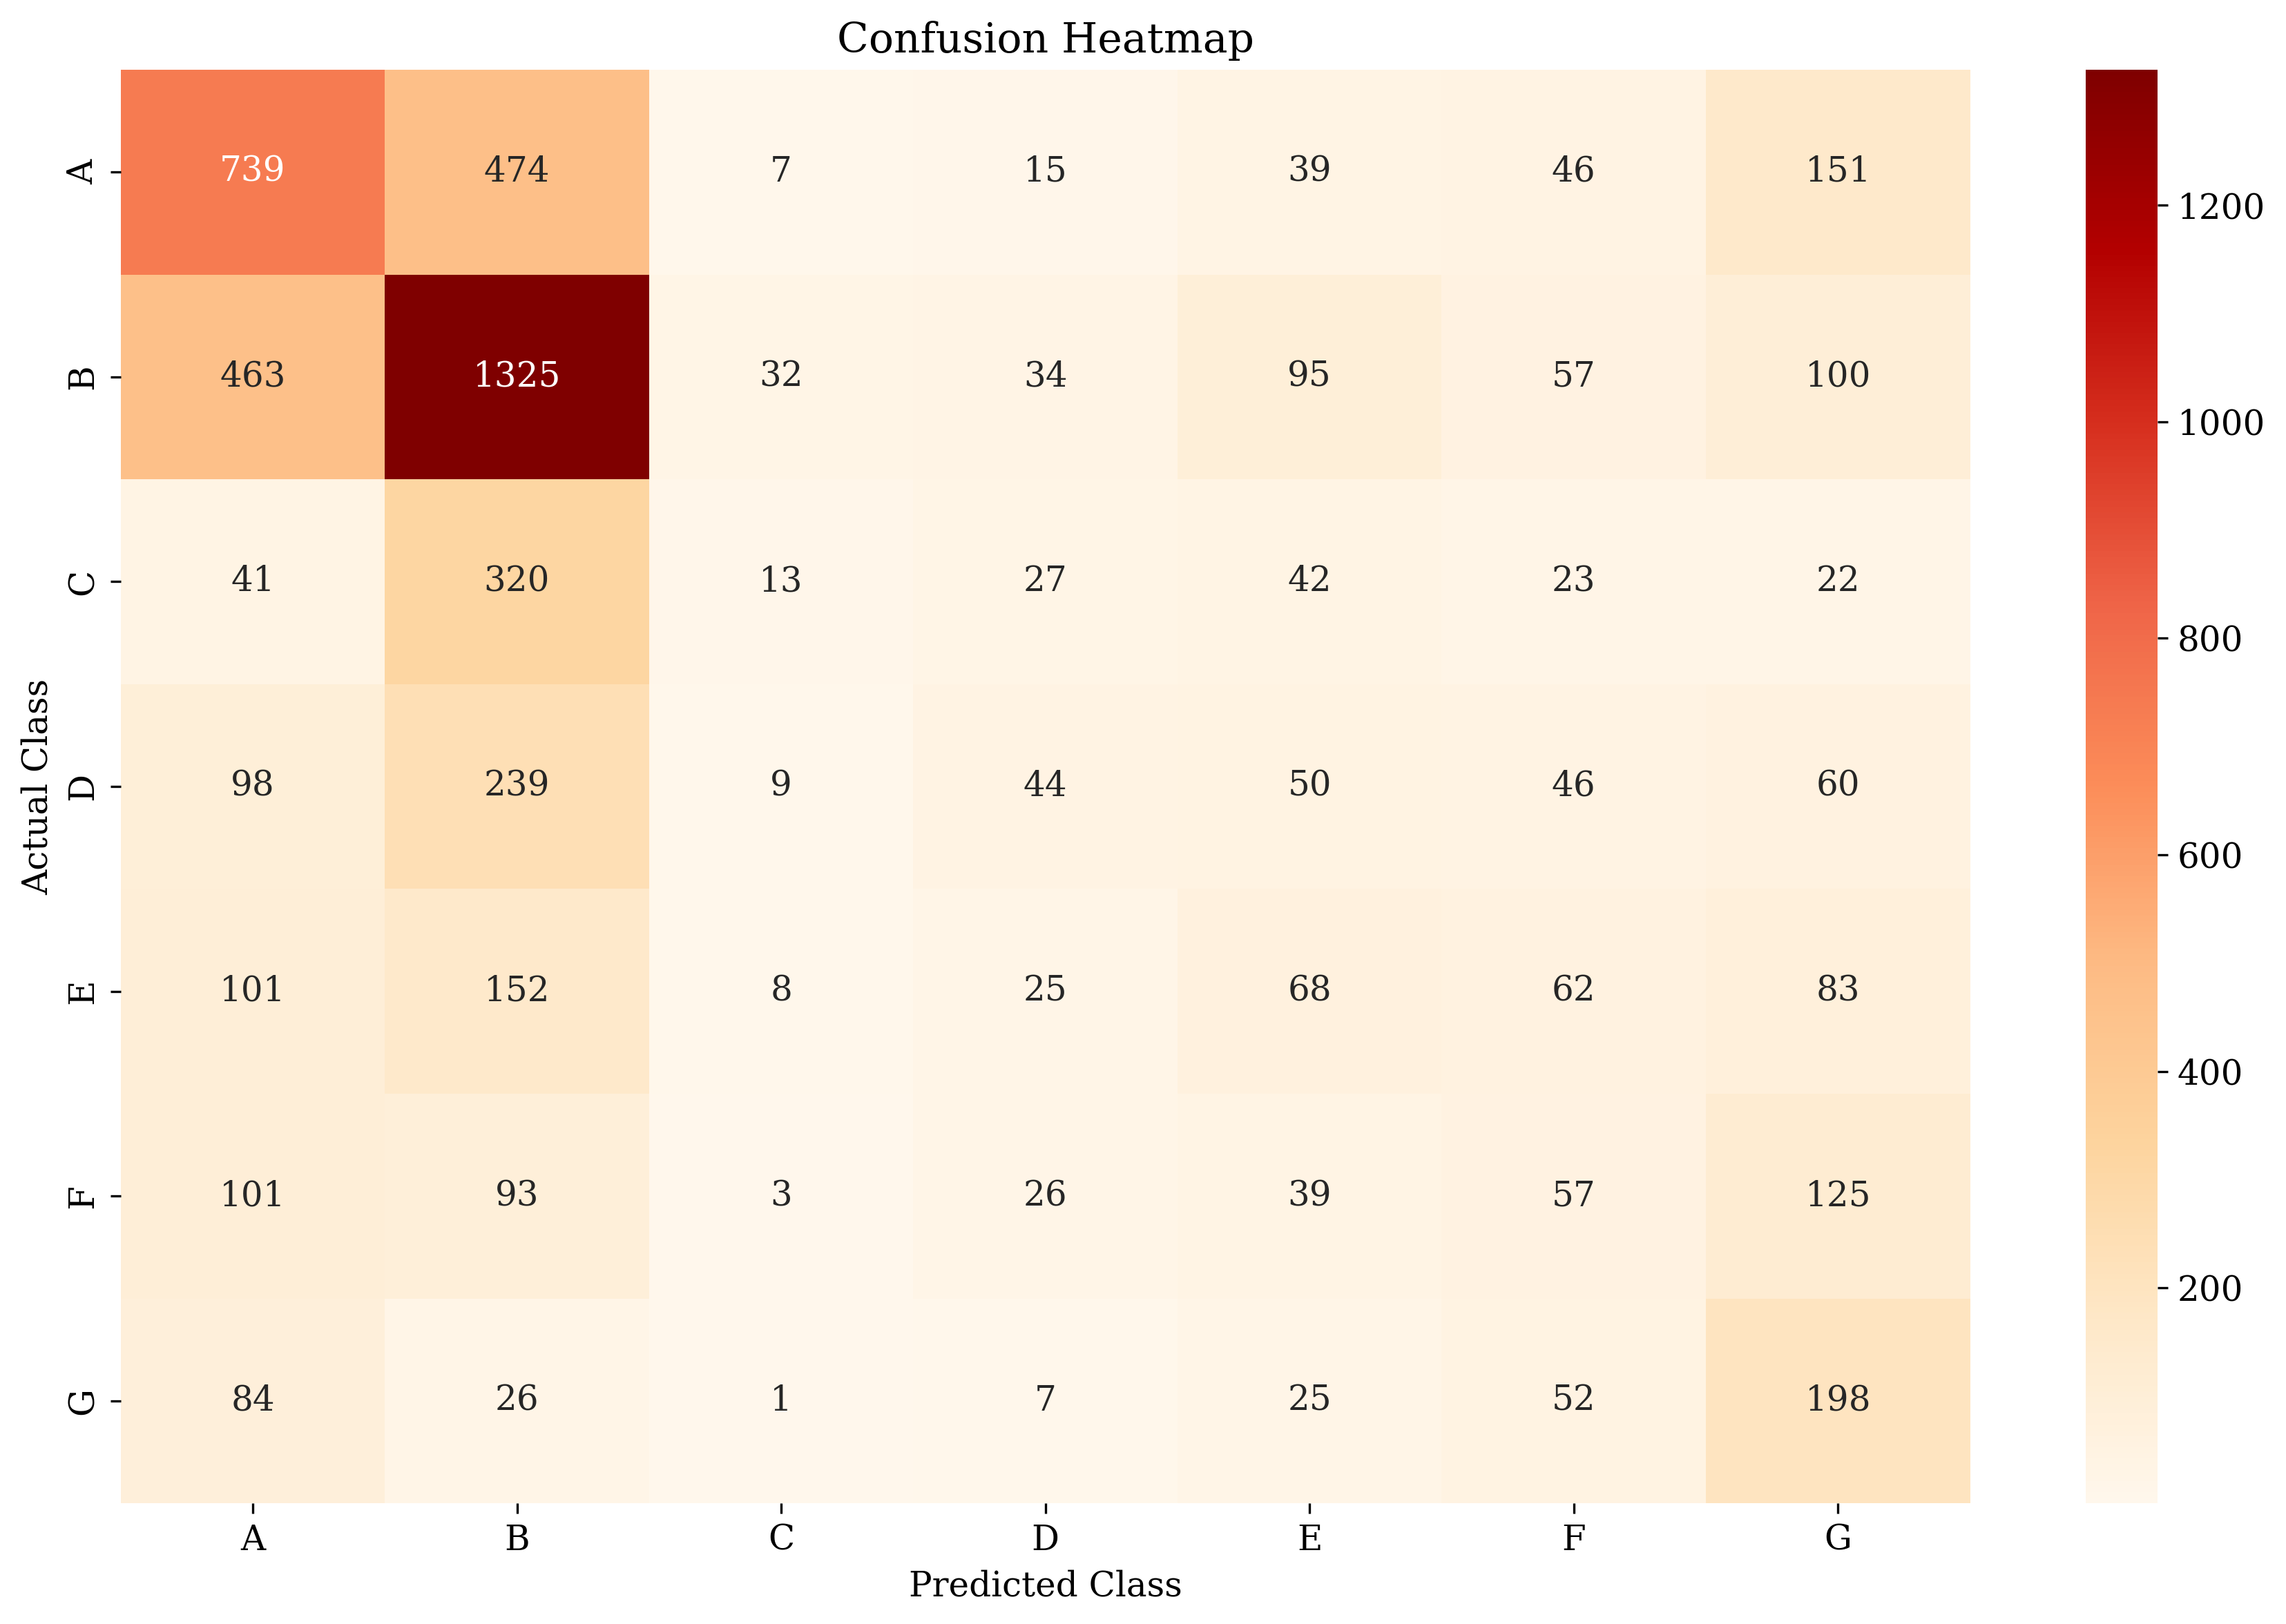

              precision    recall  f1-score   support

           A       0.45      0.50      0.48      1471
           B       0.50      0.63      0.56      2106
           C       0.18      0.03      0.05       488
           D       0.25      0.08      0.12       546
           E       0.19      0.14      0.16       499
           F       0.17      0.13      0.14       444
           G       0.27      0.50      0.35       393

    accuracy                           0.41      5947
   macro avg       0.29      0.29      0.27      5947
weighted avg       0.37      0.41      0.38      5947



In [52]:
model_utils.PlotConfusionMatrix(smote_logreg, X_test_transformed, y_test)

In this instance, we see that the accuracy has improved, but the model is still makes a lot of errors when predicting the minority classes, which SMOTE aimed to alleviate. The f1 scores achieved by SMOTE are worse than those achieved when we were downsampling, which is probably due to the fact that it is hard to synthesise observations given data that is not linearly separable. 

As it scored the best results, we will use the downsampled data to optimise the model.

---
<a id='fe'></a>
## Feature Selection

As with linear regression, one of the ways we can improve our model is by selecting the most pertinent features for the model. There are a variety of ways in which we can do this, but in this instance we will be using an L1 penalty alongside alternating C values, to create models in which features are removed as part of the penalty.

In [55]:
X, y = model_utils.GenerateXy(df_condensed)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

X_train_transformed = col_transformer.fit_transform(X_train)
X_test_transformed = col_transformer.transform(X_test)

Using L1 penalty, we should be able to find the variables that account for the changes the most.

In [56]:
log_reg_l1 = LogisticRegression(solver='liblinear', penalty='l1')
log_reg_l1.fit(X_train_transformed, y_train);

In [57]:
print(log_reg_l1.score(X_test_transformed, y_test))

0.31842966194111233


In [58]:
c_values = [10 ** x for x in range(-6, 6)]

train_accuracies = []
test_accuracies = []

for index, c in enumerate(c_values):
    print(f'Fitting Model {index+1}/{len(c_values)}', end='\r')
    log_reg_l1 = LogisticRegression(solver='liblinear', penalty='l1', C=c, random_state=1)
    log_reg_l1.fit(X_train_transformed, y_train)
    
    train_accuracies.append(log_reg_l1.score(X_train_transformed, y_train))
    test_accuracies.append(log_reg_l1.score(X_test_transformed, y_test))    

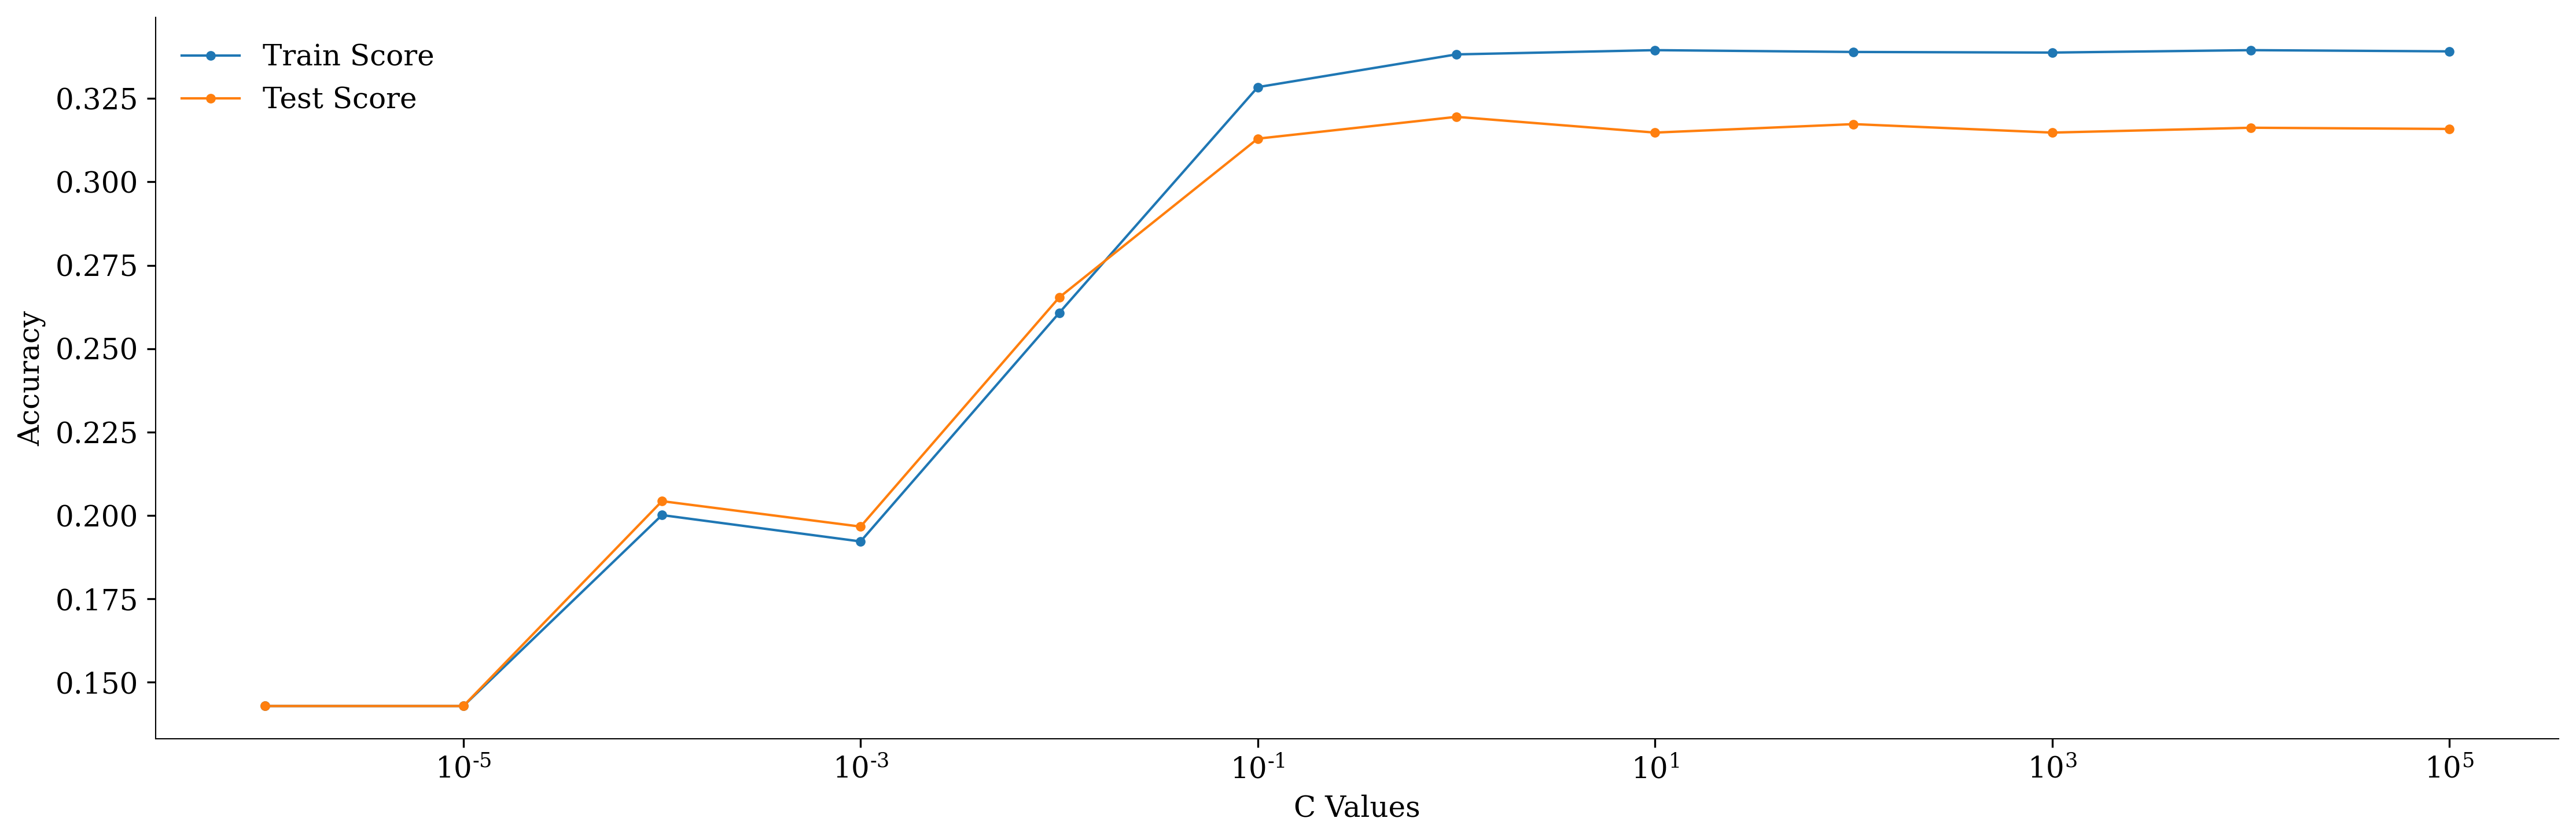

In [59]:
model_utils.PlotTrainTest(c_values, 'C Values', train_accuracies, test_accuracies, log=True)

In [60]:
print(f'The highest test accuracy was achieved with a c value of {c_values[np.argmax(test_accuracies)]}')

The highest test accuracy was achieved with a c value of 1


In [62]:
log_reg_c = LogisticRegression(solver='liblinear', penalty='l1', C=1)
log_reg_c.fit(X_train_transformed, y_train)

print(f'Test accuracy with a c value of 1: {log_reg_c.score(X_test_transformed, y_test)}')

Test accuracy with a c value of 1: 0.3187931661214104


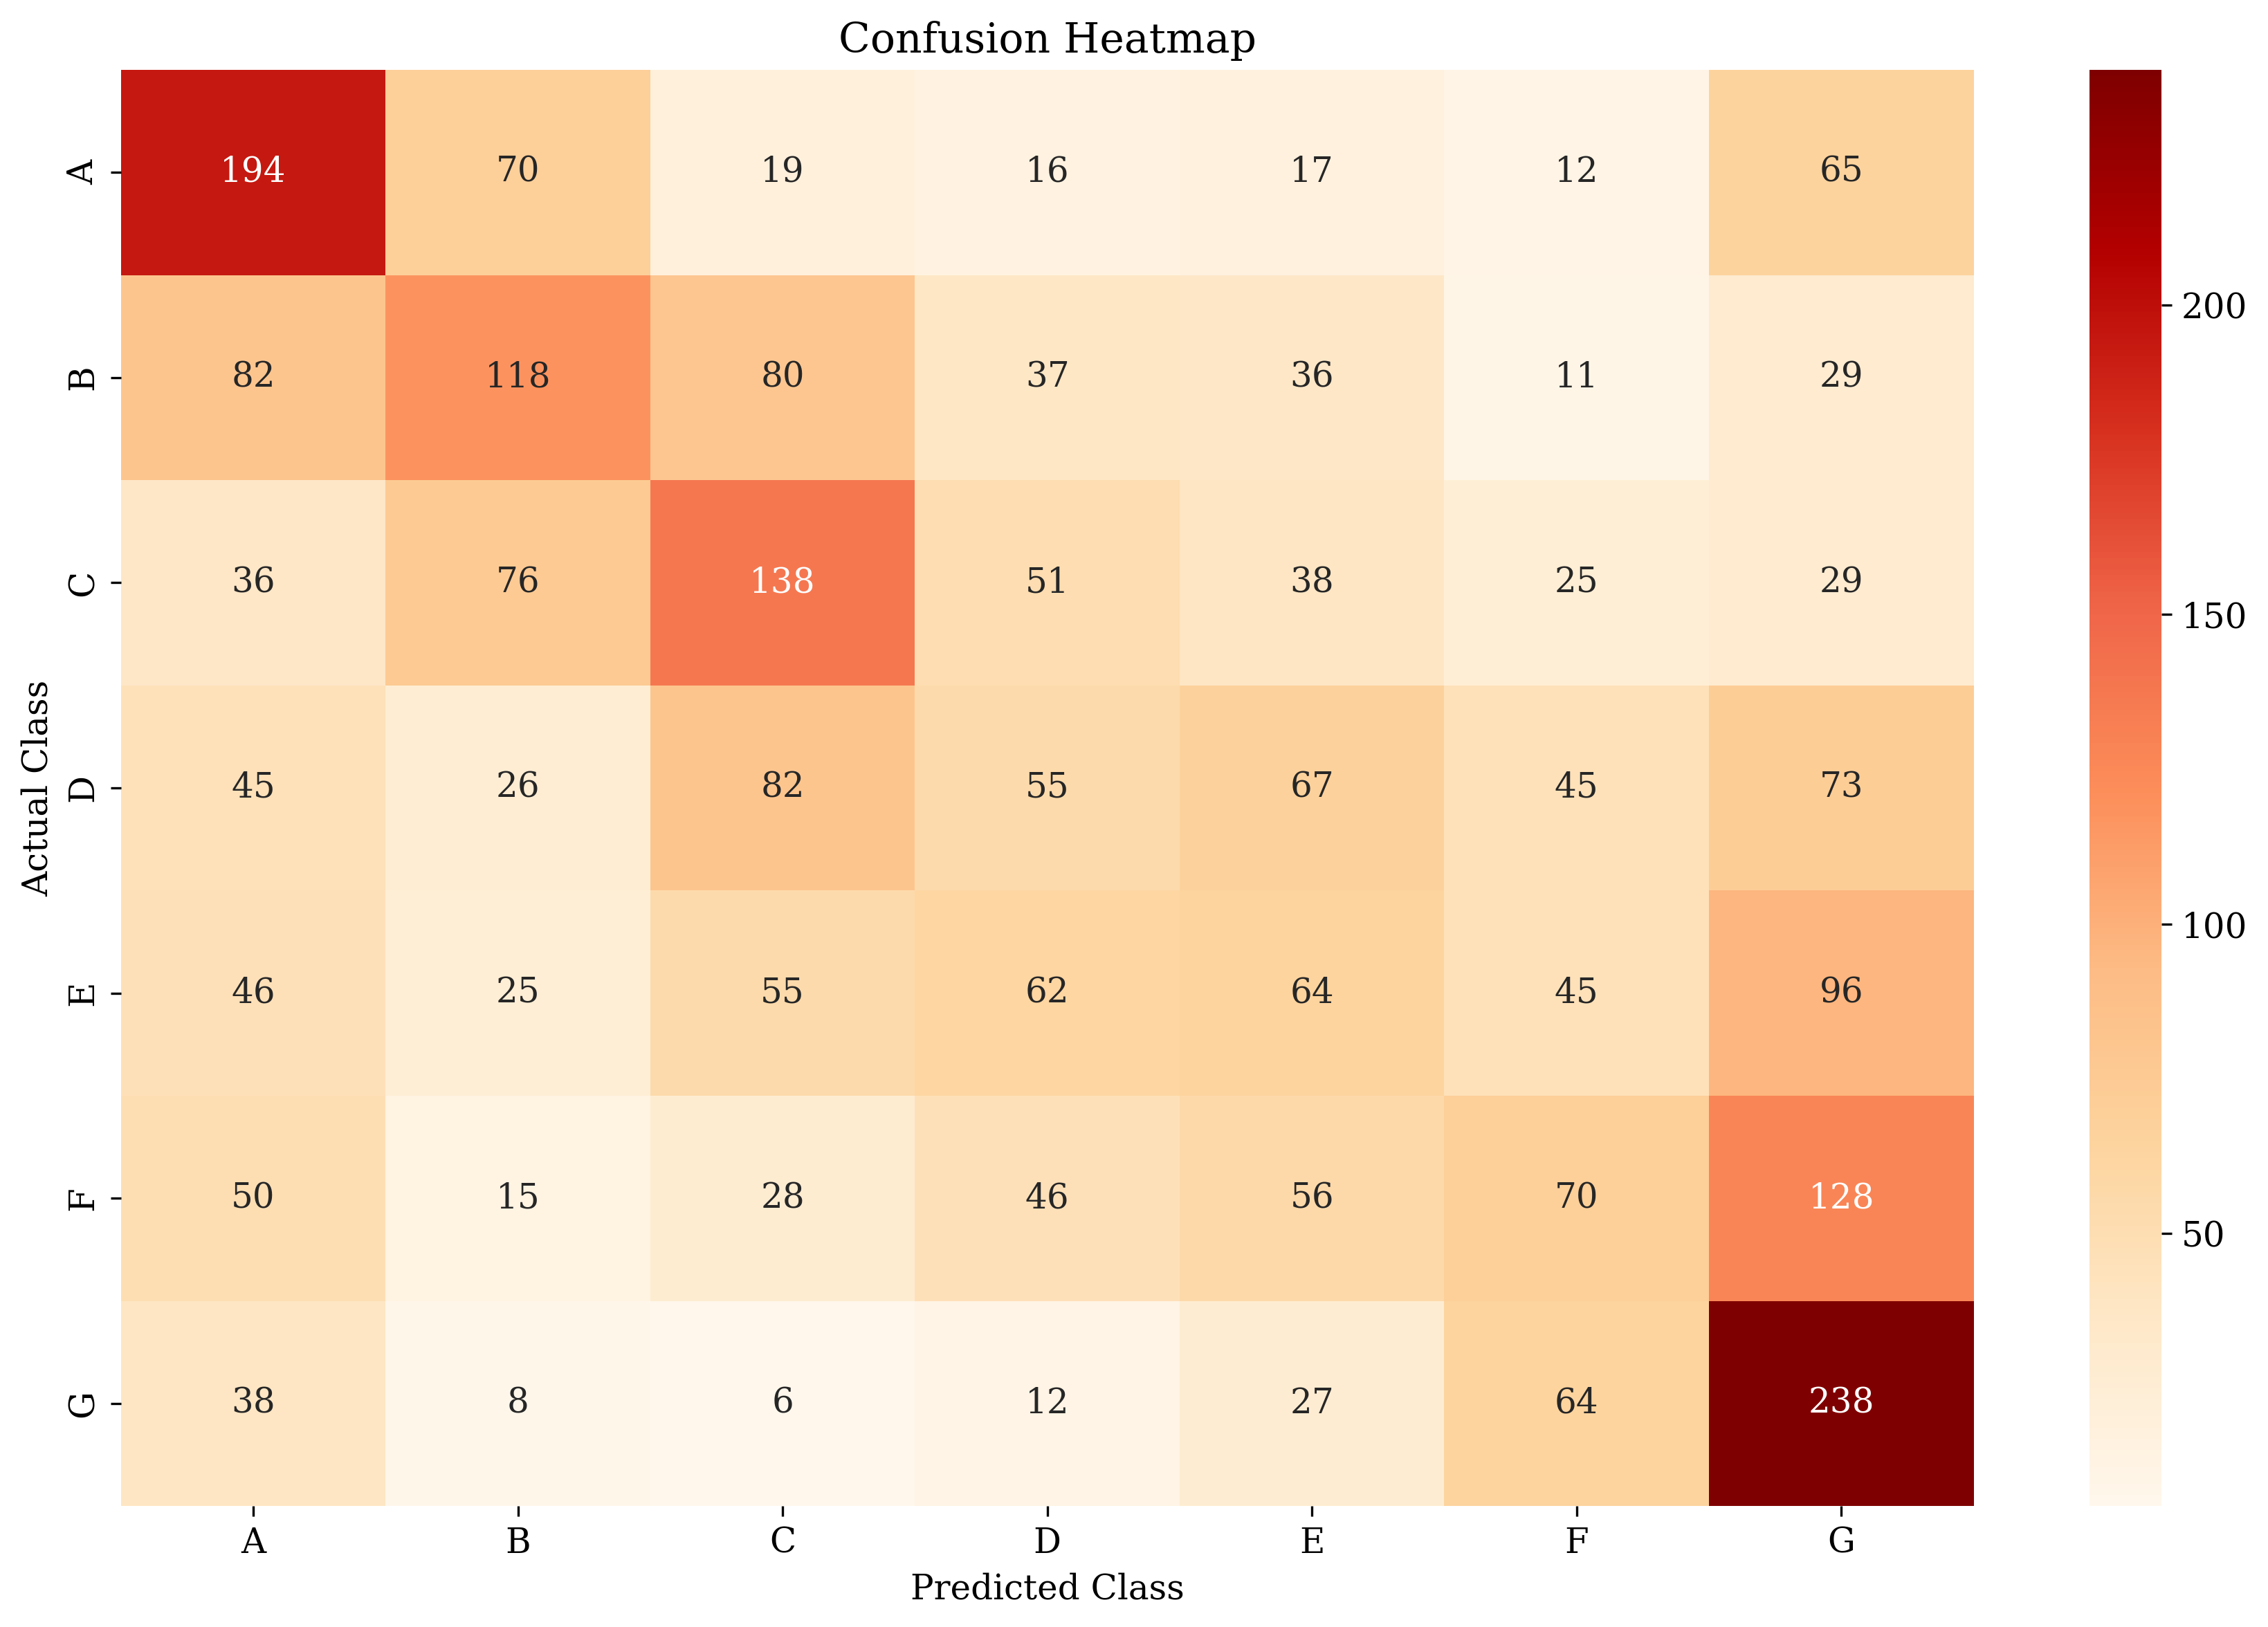

              precision    recall  f1-score   support

           A       0.40      0.49      0.44       393
           B       0.35      0.30      0.32       393
           C       0.34      0.35      0.34       393
           D       0.20      0.14      0.16       393
           E       0.21      0.16      0.18       393
           F       0.26      0.18      0.21       393
           G       0.36      0.61      0.45       393

    accuracy                           0.32      2751
   macro avg       0.30      0.32      0.30      2751
weighted avg       0.30      0.32      0.30      2751



In [63]:
model_utils.PlotConfusionMatrix(log_reg_c, X_test_transformed, y_test)

What are the values that the model deems the most important? Using a lower C value will reduce the number of features in the model as it will reduce their coefficients to 0. We can therefore use the L1 penalty in conjunction with a low C value to extract the most informative features.

In [64]:
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=0.0001)
logreg.fit(X_train_transformed, y_train)

LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')

In [65]:
pd.set_option('display.max_columns', None)

In [66]:
pd.DataFrame(logreg.coef_, columns=X.columns)

,FIRE_YEAR,DISCOVERY_DOY,LATITUDE,LONGITUDE,avg_tempmax,avg_temp,avg_humidity,avg_precip,avg_dew,avg_windspeed,avg_winddir,avg_pressure,ch4,co2,n2o,tempmax_variance,tempmax_delta,temp_variance,temp_delta,humidity_variance,humidity_delta,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001300,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001972,0.0,0.0,-0.000747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001620,0.0,0.0,-0.001472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.002753,0.0,0.0,-0.001185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.008036,0.0,0.0,-0.003235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.012079,0.0,0.0,-0.003765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.018753,0.0,0.0,-0.004875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


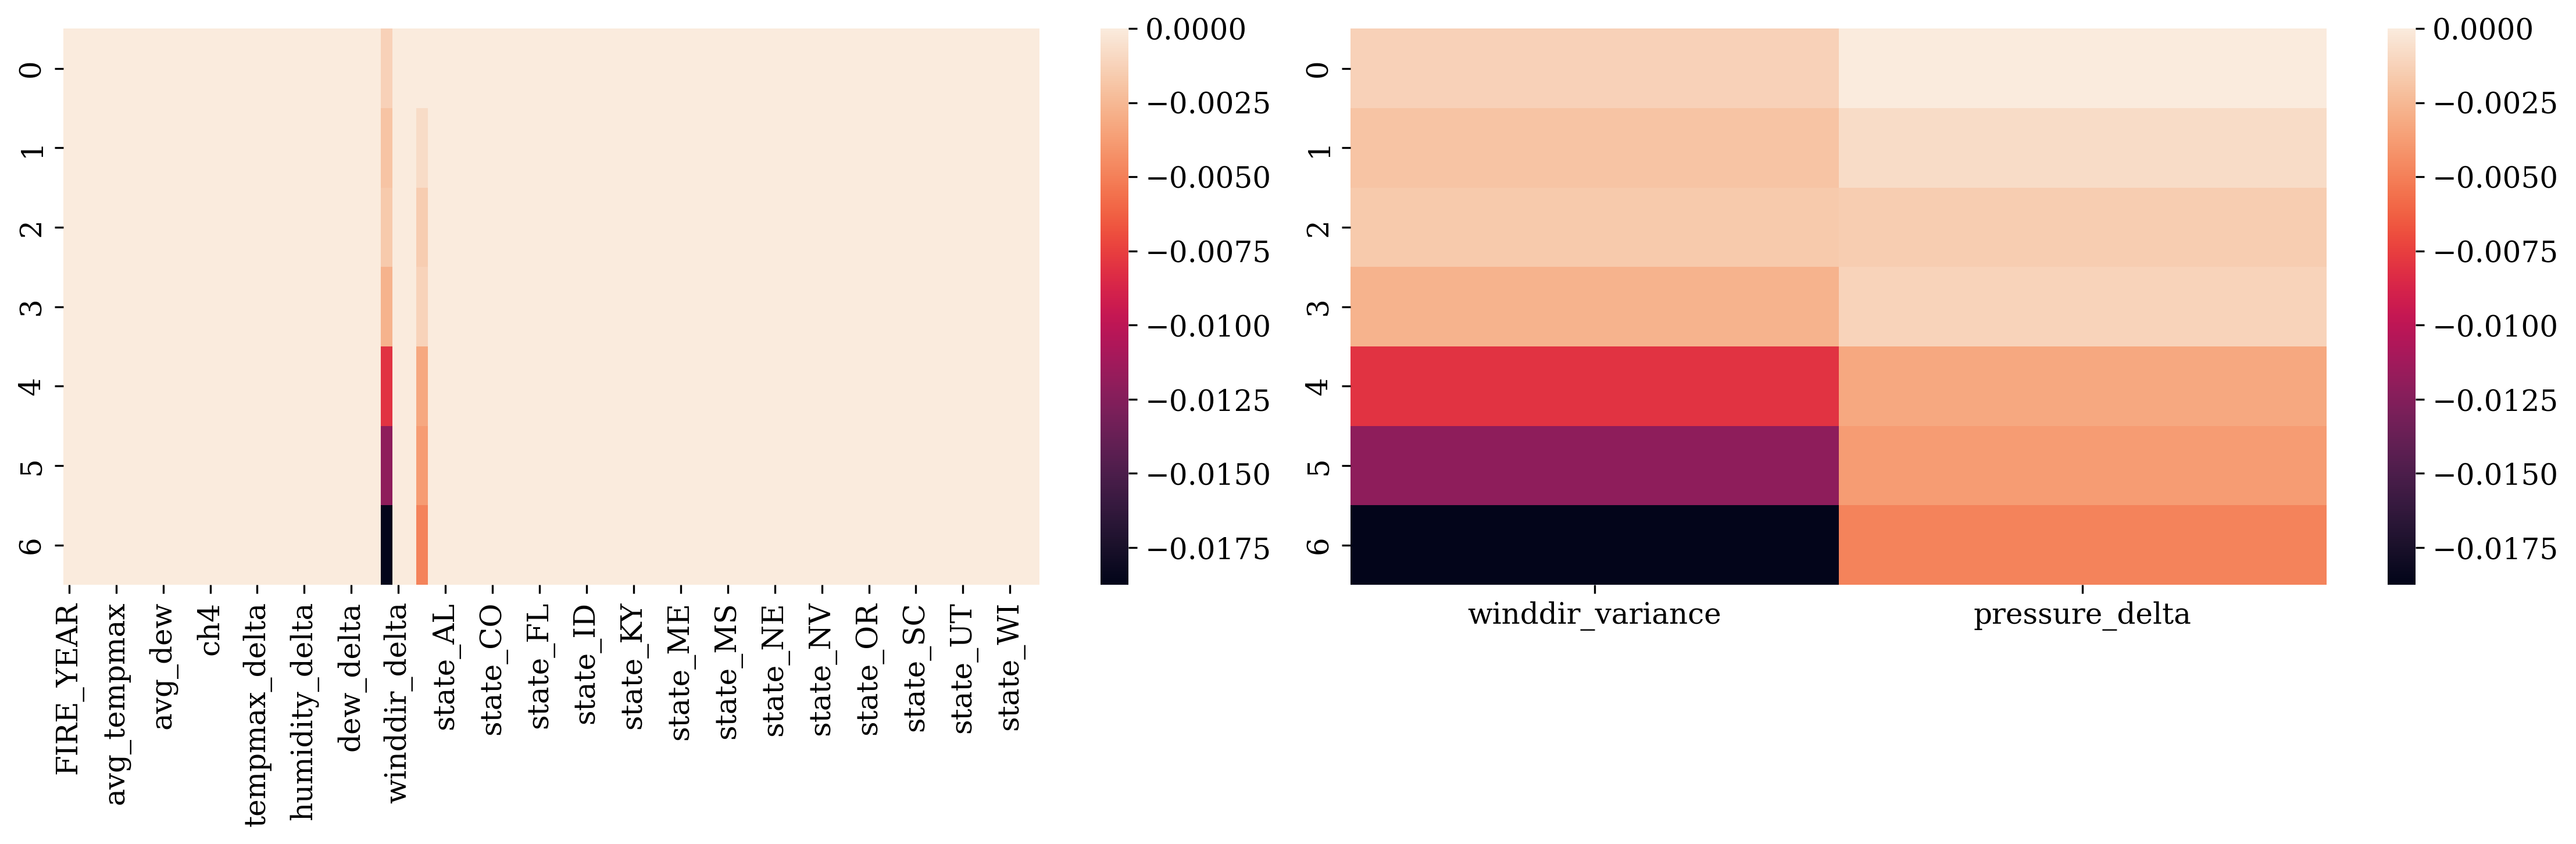

In [69]:
plt.subplots(1, 2, dpi=300, figsize=(15, 5))

# Give DataFrame variable name 
coefficients = pd.DataFrame(logreg.coef_, columns=X.columns)

# Calculate non-zero columns
non_zero_cols = [col for col in coefficients 
                 if sum(coefficients[col]) != 0]

# General Overview
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(logreg.coef_, columns=X.columns))

# Specific features
plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(logreg.coef_, columns=X.columns).loc[:, non_zero_cols])

plt.show()

These variables, having used the L1 penalty as a form of feature selection, are the most important. We can therefore build another model which only looks at these values.

In [75]:
X_reduced = X.loc[:, non_zero_cols]

# Create remainder and test
X_train, X_test, y_train, y_test = \
train_test_split(X_reduced, y, test_size=0.2, random_state=1, stratify=y)

In [76]:
from sklearn.preprocessing import StandardScaler

my_ss = StandardScaler()
X_train_transformed = my_ss.fit_transform(X_train)
X_test_transformed = my_ss.transform(X_test)

In [77]:
logreg_reduced = LogisticRegression(random_state=1)
logreg_reduced.fit(X_train_transformed, y_train);

In [78]:
logreg_reduced.score(X_test_transformed, y_test)

0.173391494002181

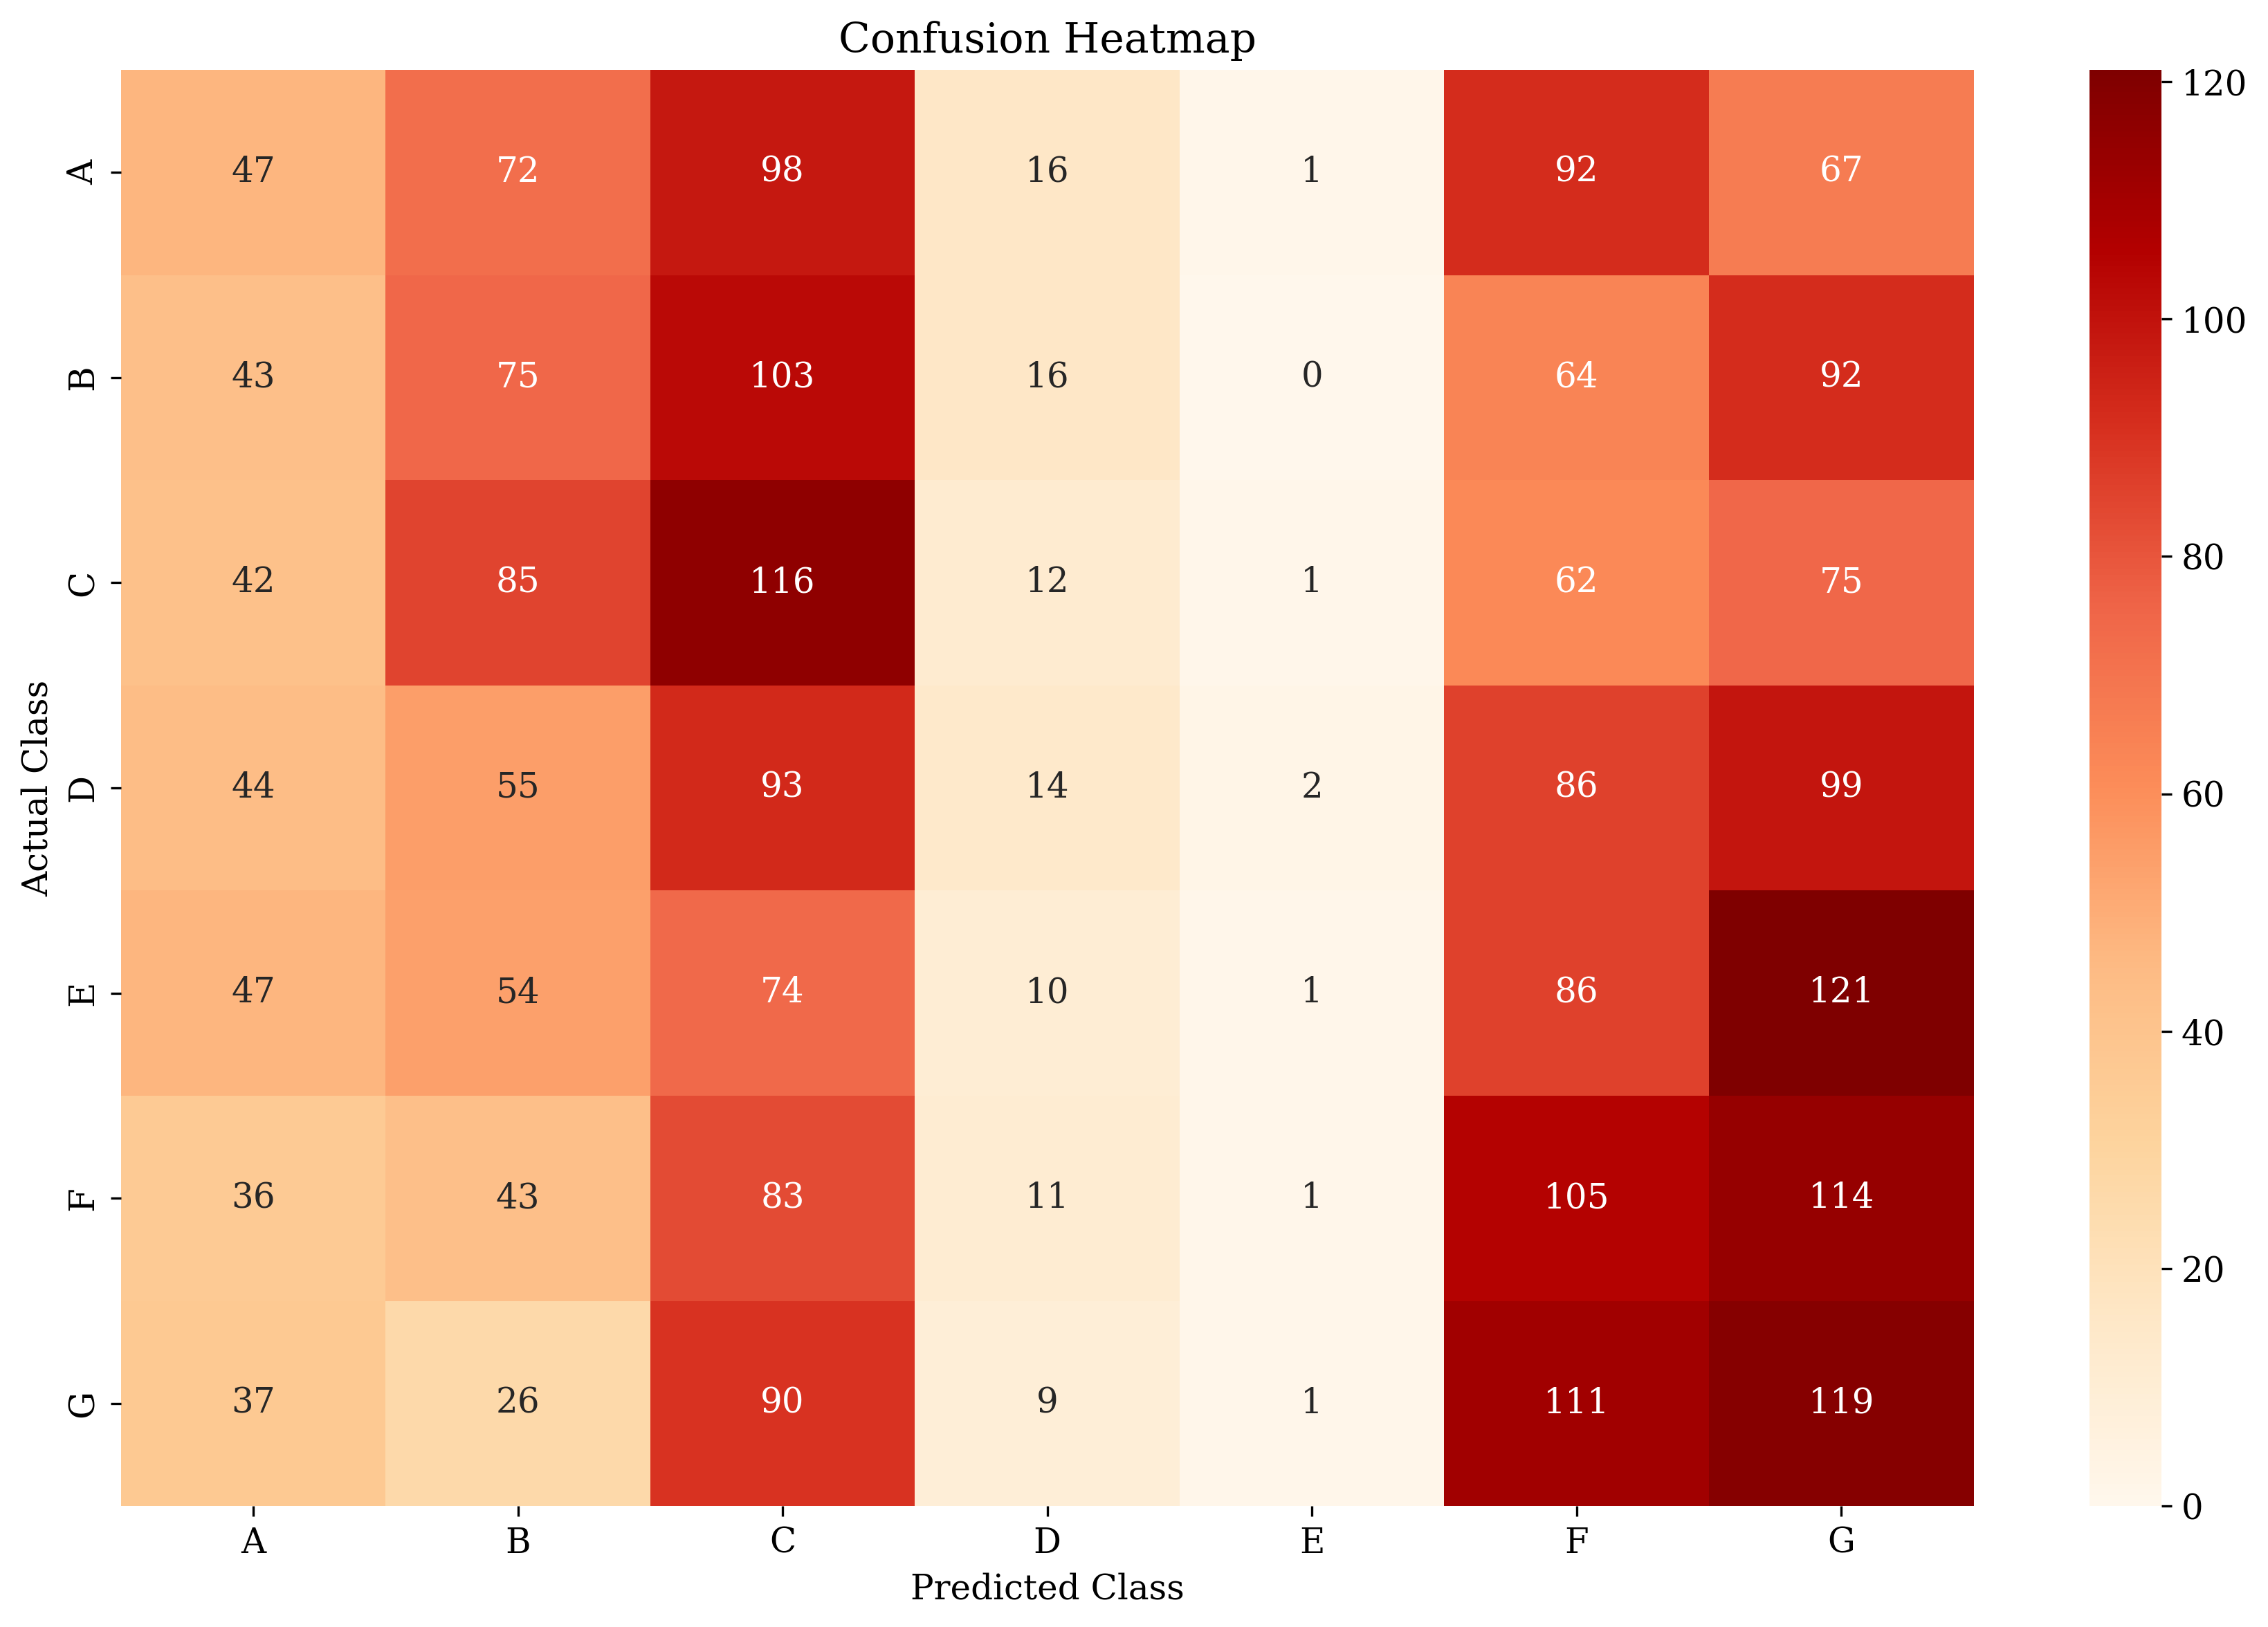

              precision    recall  f1-score   support

           A       0.16      0.12      0.14       393
           B       0.18      0.19      0.19       393
           C       0.18      0.30      0.22       393
           D       0.16      0.04      0.06       393
           E       0.14      0.00      0.01       393
           F       0.17      0.27      0.21       393
           G       0.17      0.30      0.22       393

    accuracy                           0.17      2751
   macro avg       0.17      0.17      0.15      2751
weighted avg       0.17      0.17      0.15      2751



In [79]:
model_utils.PlotConfusionMatrix(logreg_reduced, X_test_transformed, y_test)

We see that building a model with only these two variables is unable to create a robust model. Instead, we can attempt to reduce the dimensionality of the model using principal component analysis.

---
<a id='dim_reduc'></a>
## Reducing Dimensionality with PCA

We can try to reduce the dimensionality of the model, not through feature selection, but by using PCA. In doing so, we are hoping to explain the variance of the model using principal components which will hopefully create a more robust model.

We can start by creating a simple PCA model that initially does not change the dimensionality of the model, but creates an equal number of principal components.

In [80]:
from sklearn.decomposition import PCA

X, y = model_utils.GenerateXy(df_condensed)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

X_train_transformed = col_transformer.fit_transform(X_train)
X_test_transformed = col_transformer.transform(X_test)

# Instantiate PCA
my_pca = PCA()

# Fit to scaled data
X_train_pca = my_pca.fit_transform(X_train_transformed)
X_test_pca = my_pca.transform(X_test_transformed)

In [81]:
X_train_pca.shape

(11004, 83)

In [83]:
logreg = LogisticRegression(max_iter=10000, random_state=1)
logreg.fit(X_train_pca, y_train)
logreg.score(X_test_pca, y_test)

print(f'The PCA model achieved {logreg.score(X_test_transformed, y_test):.4f} accuracy.')

0.31624863685932386

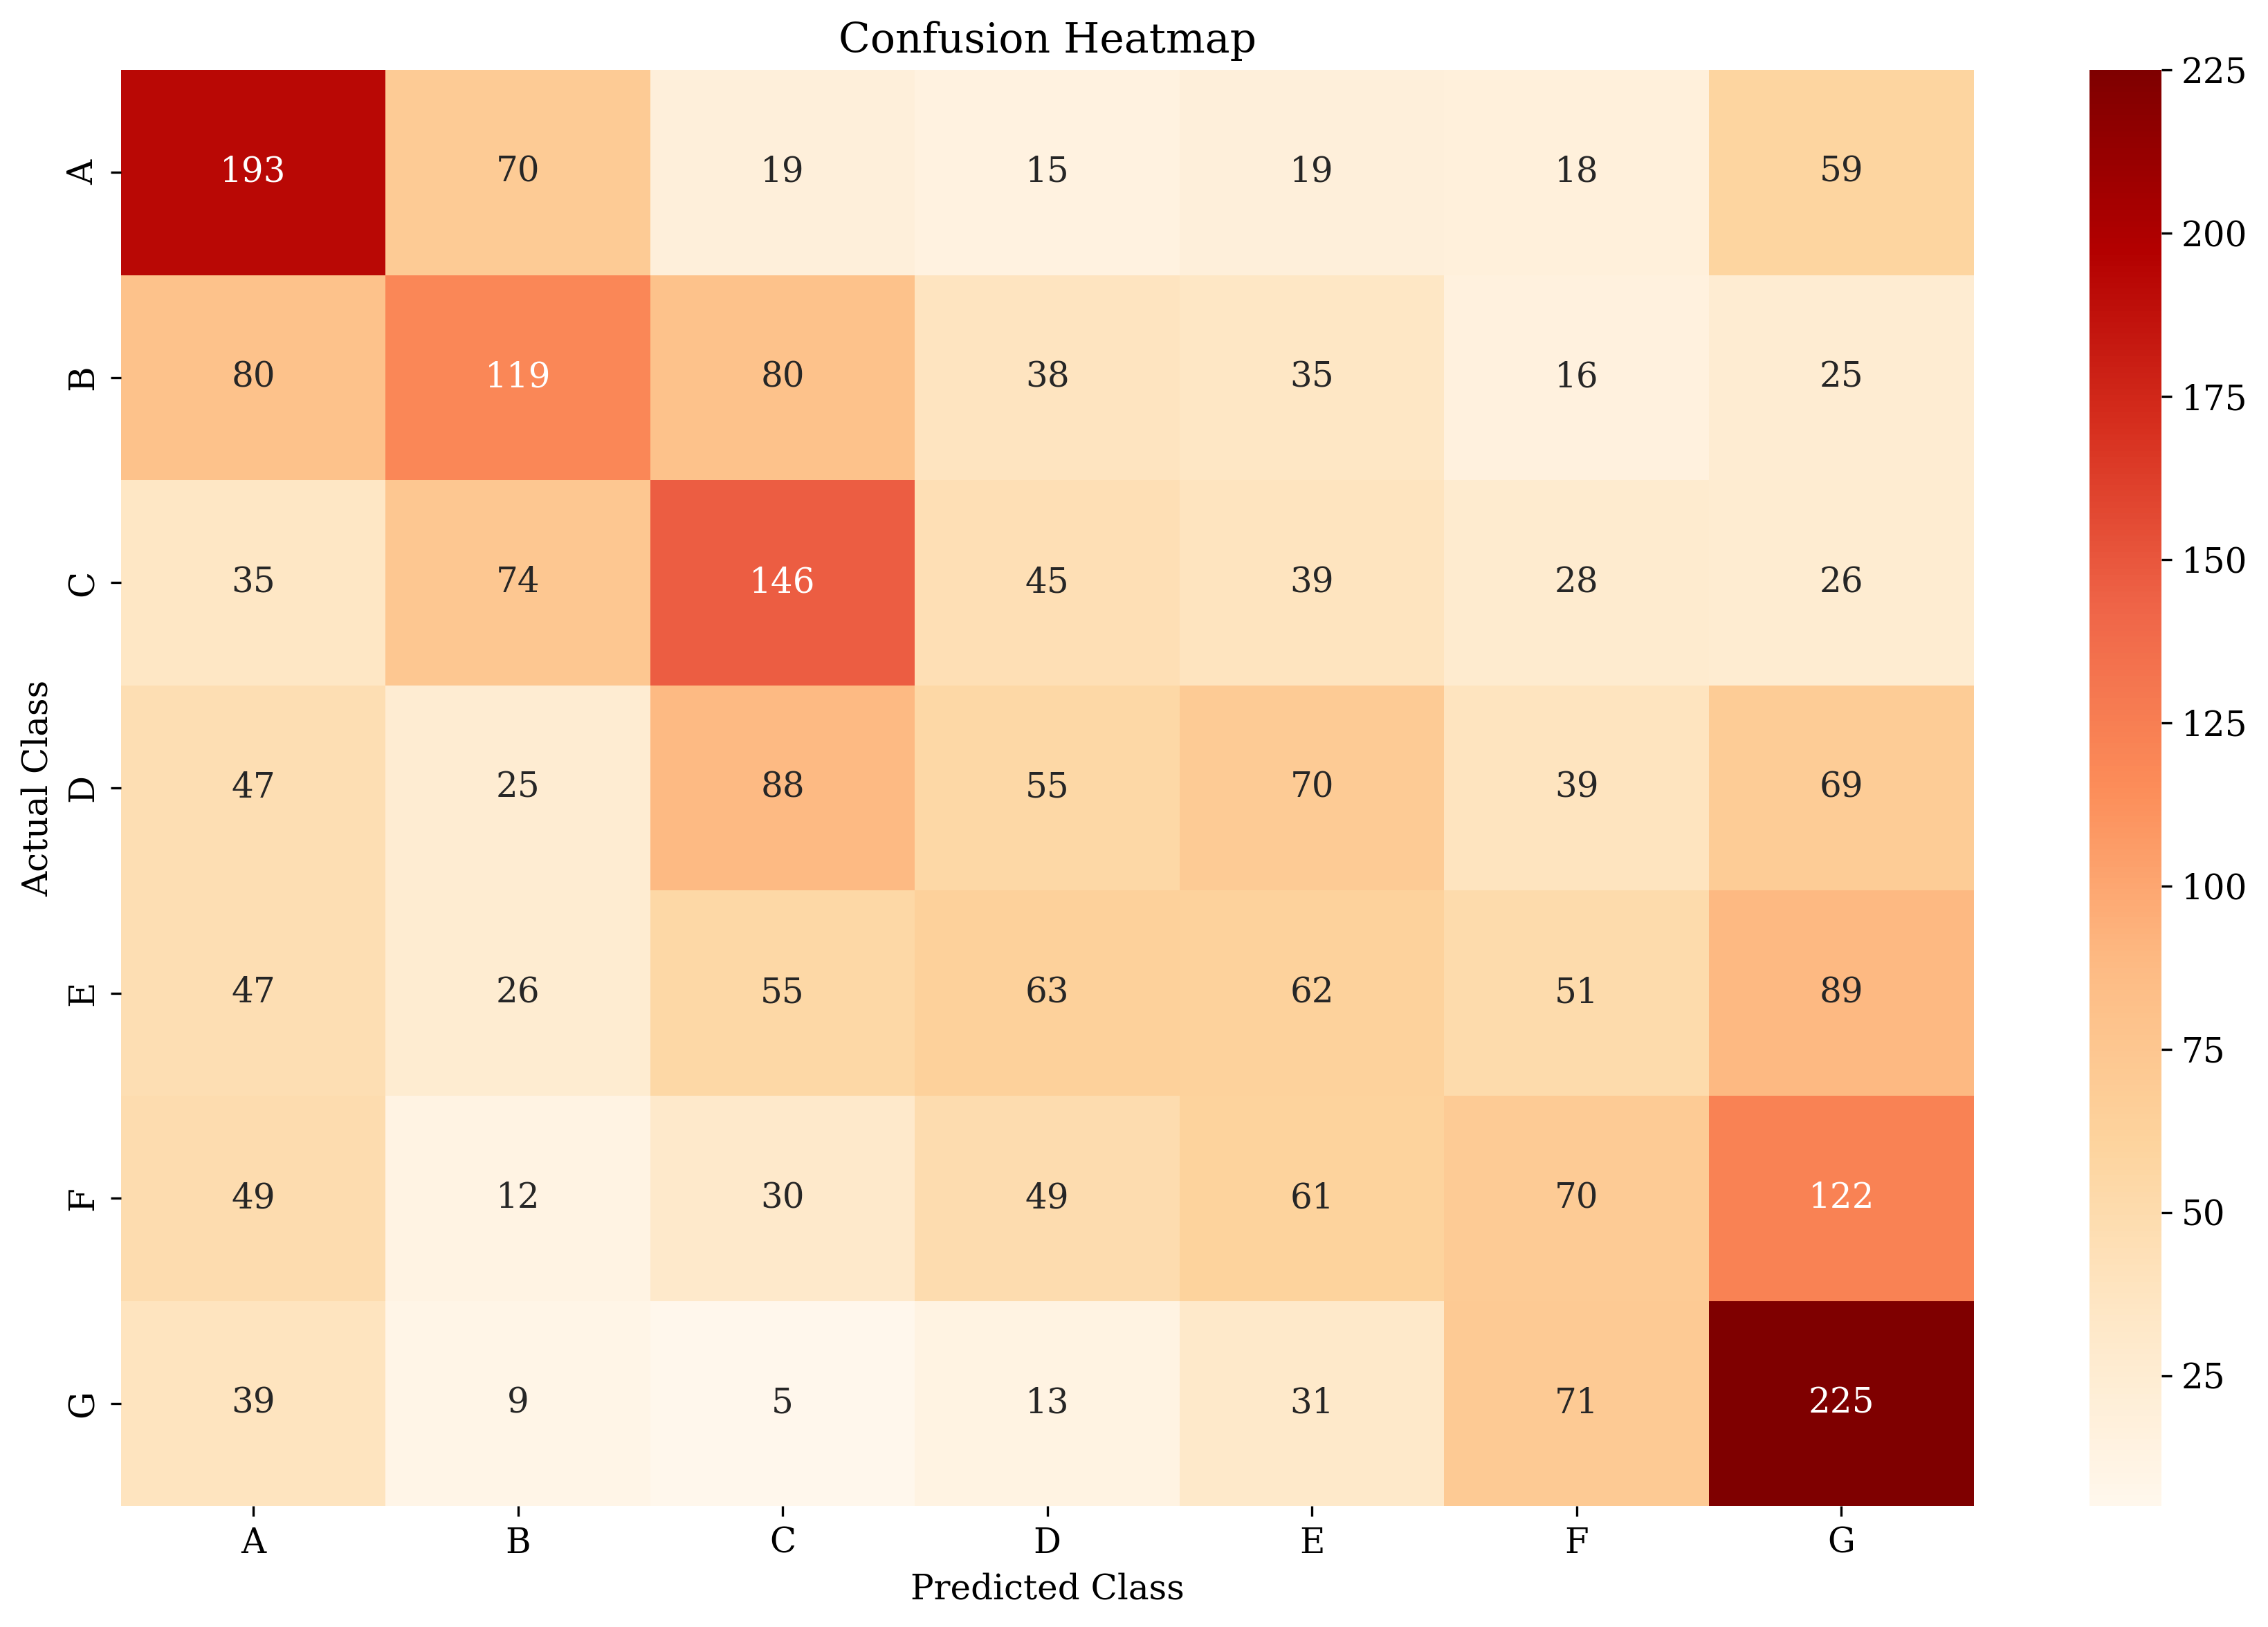

              precision    recall  f1-score   support

           A       0.39      0.49      0.44       393
           B       0.36      0.30      0.33       393
           C       0.35      0.37      0.36       393
           D       0.20      0.14      0.16       393
           E       0.20      0.16      0.17       393
           F       0.24      0.18      0.20       393
           G       0.37      0.57      0.45       393

    accuracy                           0.32      2751
   macro avg       0.30      0.32      0.30      2751
weighted avg       0.30      0.32      0.30      2751



In [84]:
model_utils.PlotConfusionMatrix(logreg, X_test_pca, y_test)

PCA so far has been unable to make significant changes to the model that we created without PCA. We can reduce the dimensionality by specifying the number of components that we want our PCA to create, or we can specify a percentage of the explained variance that we want. Let us take a look at the explained variance ratio to see what the principal components look like.

In [85]:
my_pca.explained_variance_ratio_

array([8.21850161e-01, 1.22162086e-01, 4.47586079e-02, 6.97213232e-03,
       1.06188812e-03, 4.98117445e-04, 4.25418675e-04, 2.90052274e-04,
       2.52122329e-04, 2.08706718e-04, 1.75863504e-04, 1.72195534e-04,
       1.55618188e-04, 1.20663624e-04, 1.11164797e-04, 1.06086476e-04,
       9.53011158e-05, 9.18243536e-05, 7.53112470e-05, 7.20127864e-05,
       6.33749292e-05, 4.90119563e-05, 2.01050212e-05, 1.85804123e-05,
       1.56813095e-05, 1.42815814e-05, 1.24163344e-05, 1.05590918e-05,
       8.78141615e-06, 8.24629374e-06, 7.78539713e-06, 7.24123936e-06,
       6.82953964e-06, 5.65289078e-06, 5.54327854e-06, 5.42621278e-06,
       5.33779211e-06, 5.21999072e-06, 5.14745313e-06, 4.69940841e-06,
       4.31918746e-06, 4.16519603e-06, 4.05032920e-06, 3.66054339e-06,
       3.53166632e-06, 3.39005481e-06, 3.06507237e-06, 2.99208140e-06,
       2.86873159e-06, 2.80898057e-06, 2.72189259e-06, 2.63361904e-06,
       2.52566432e-06, 2.36835688e-06, 2.21901800e-06, 2.14438938e-06,
      

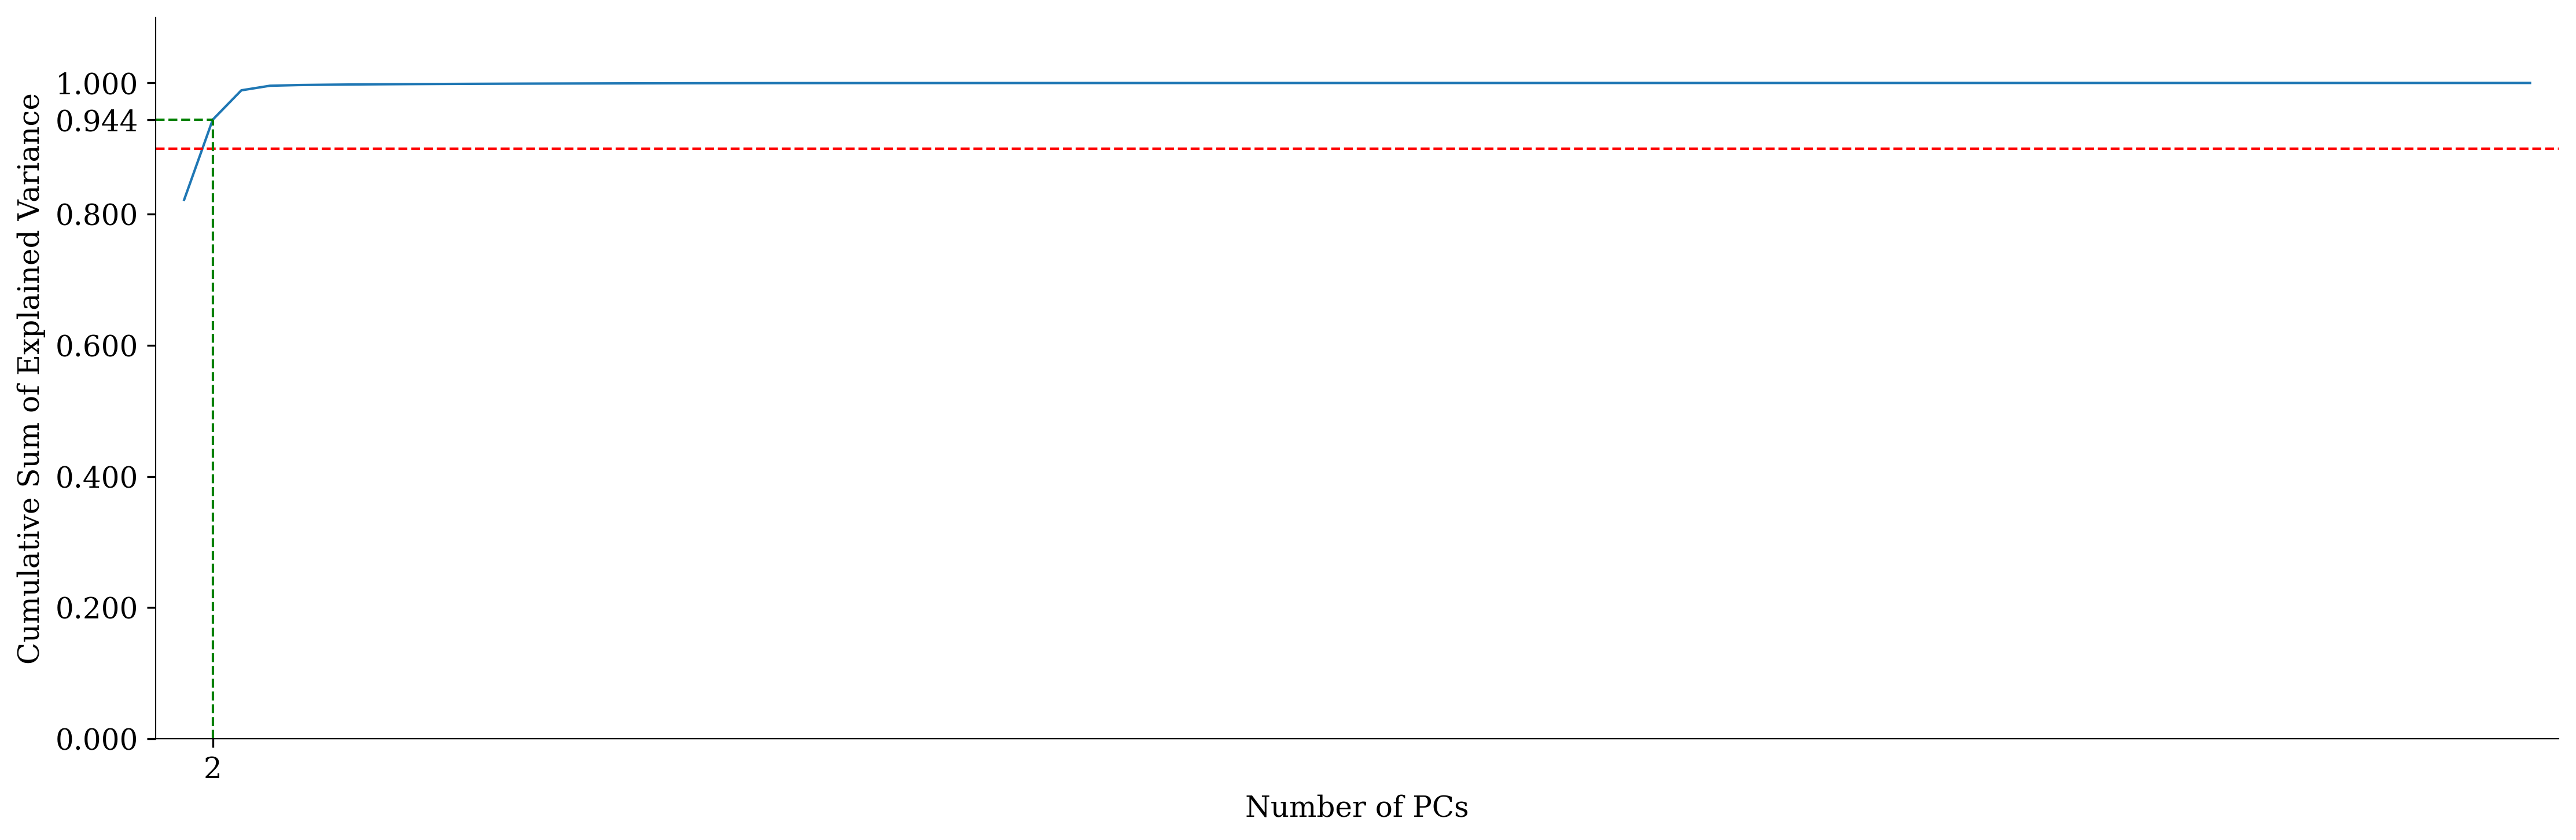

In [86]:
utils.PlotVarianceRatio(my_pca)

As we can see, only 2 principal components are required to explain 94.4% of the variance in the dataset. We can select these with the following code:

In [87]:
# Instantiate PCA
my_pca = PCA(n_components=0.9)

# Fit to scaled data
X_train_pca = my_pca.fit_transform(X_train_transformed)
X_test_pca = my_pca.transform(X_test_transformed)

In [88]:
logreg = LogisticRegression(max_iter=10000, random_state=1)
logreg.fit(X_train_pca, y_train)
logreg.score(X_test_pca, y_test)

0.18793166121410396

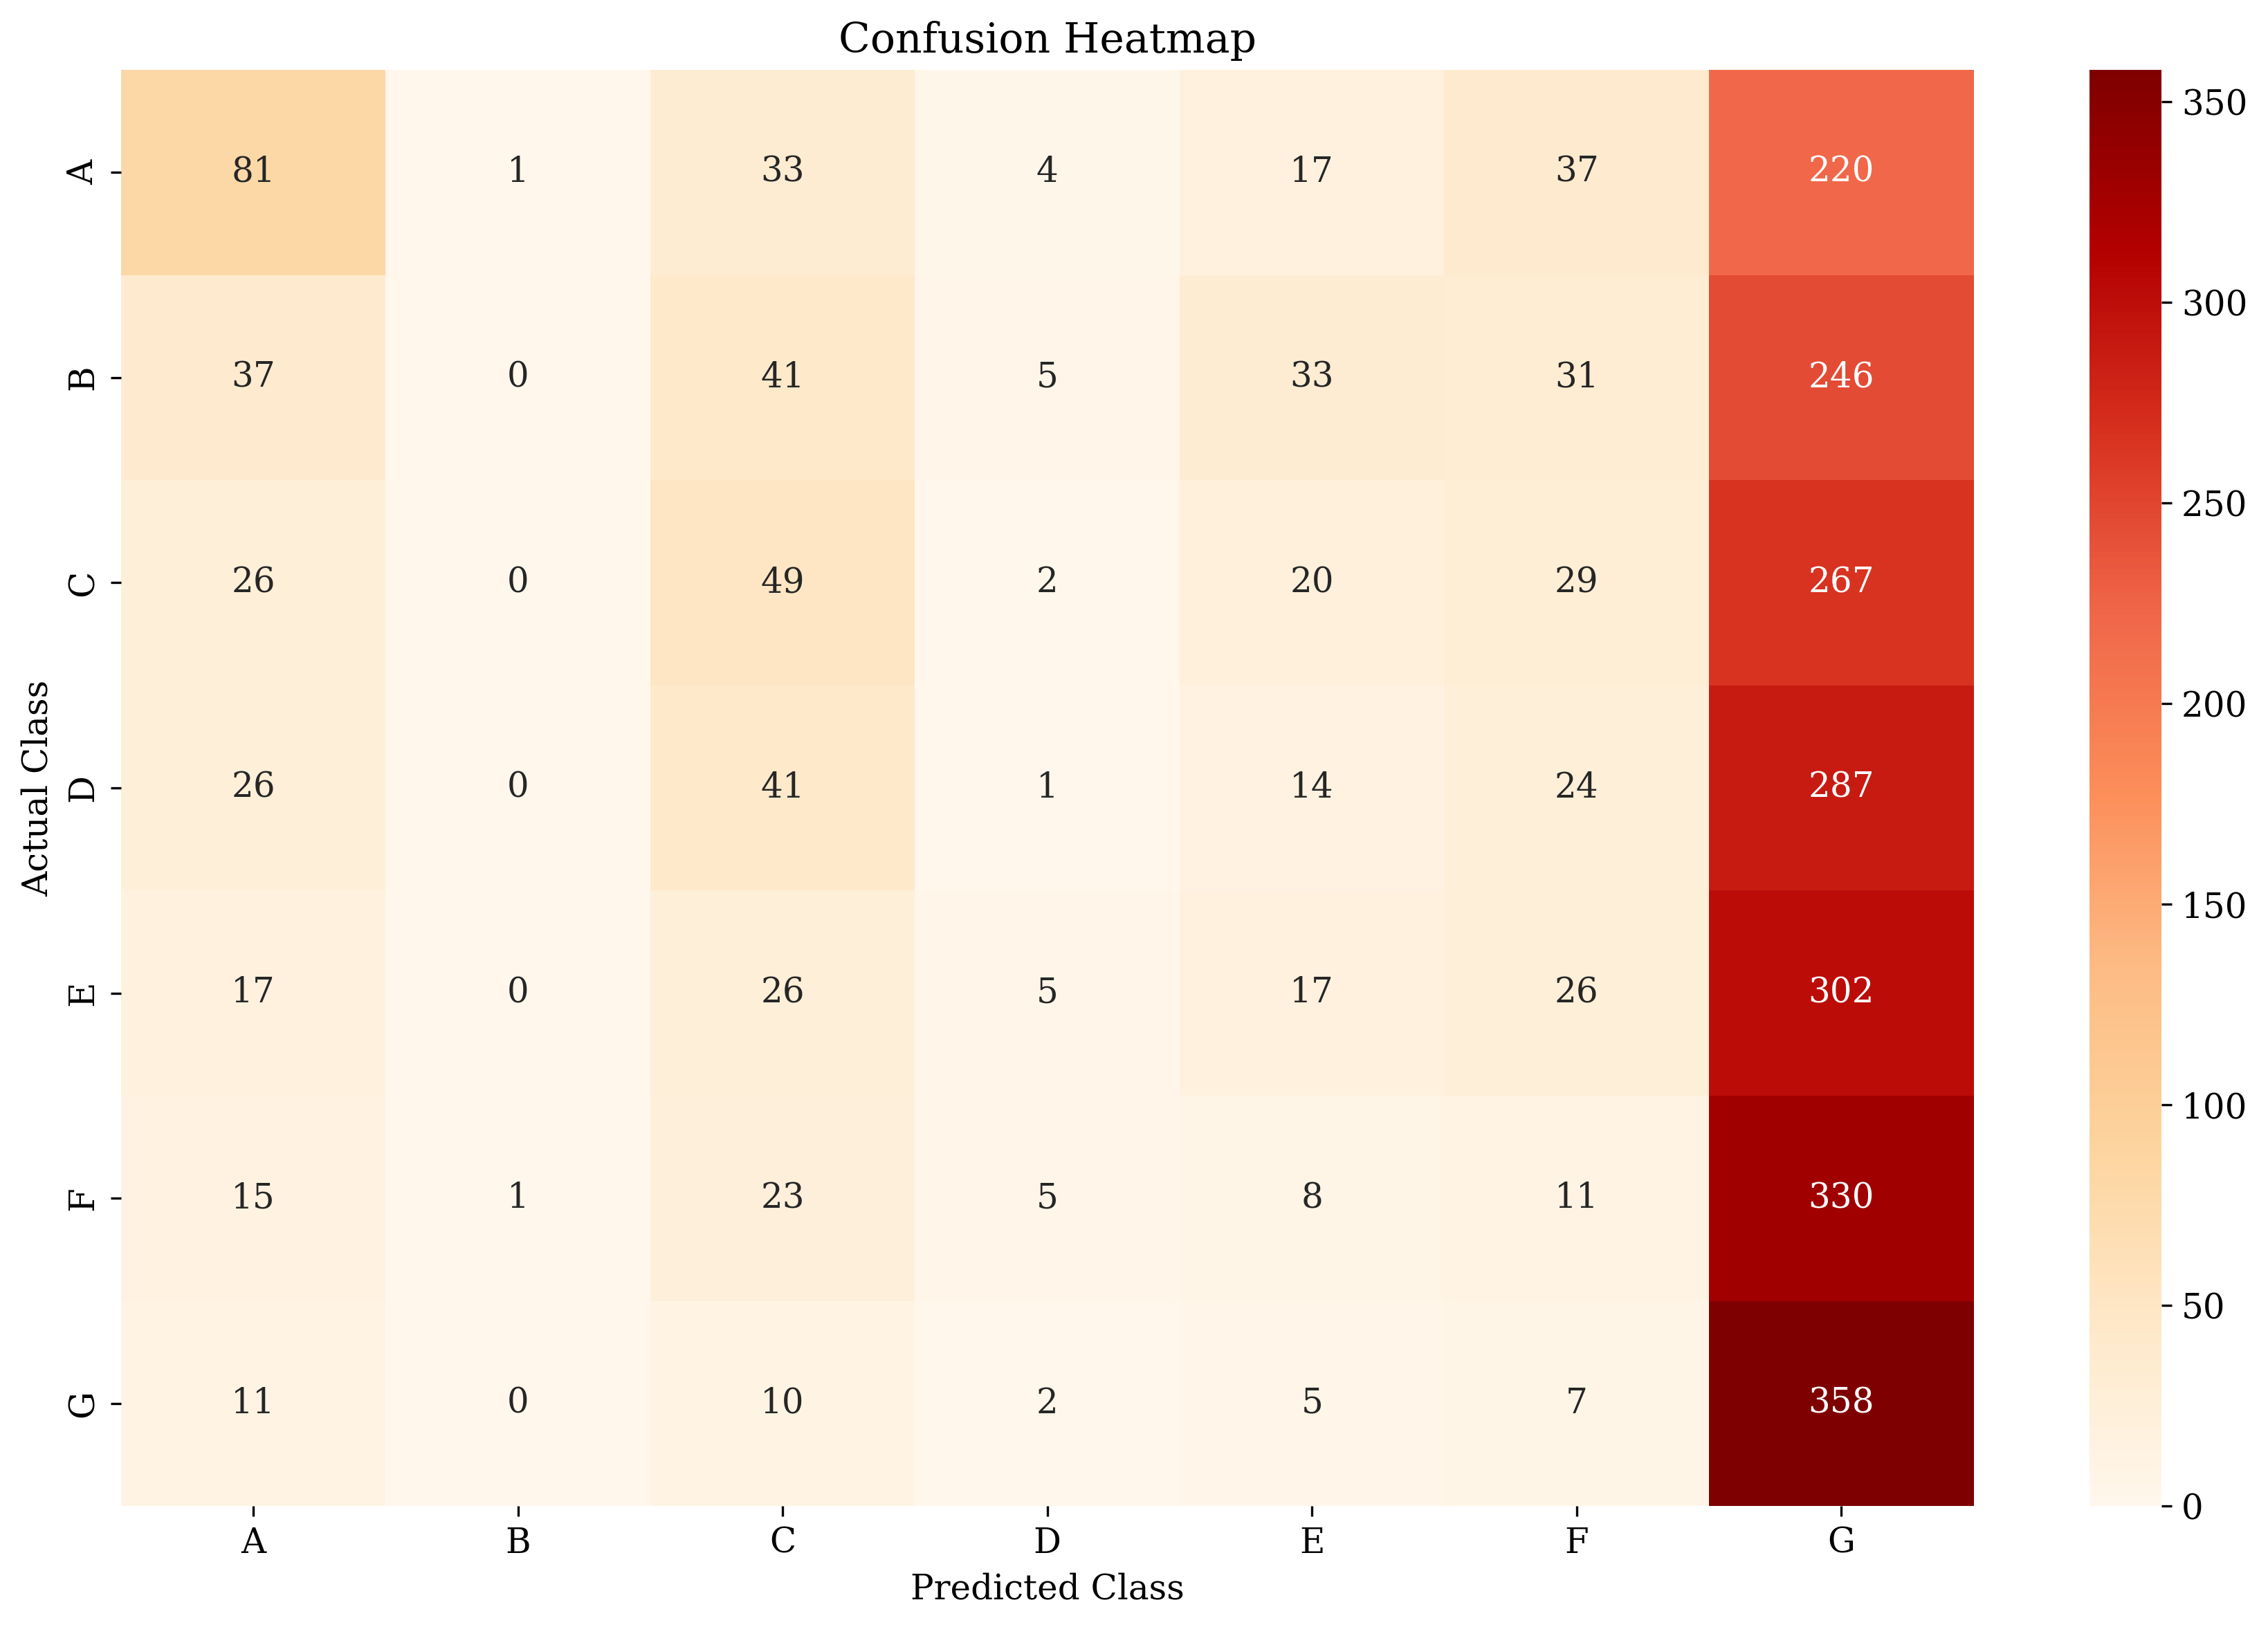

              precision    recall  f1-score   support

           A       0.38      0.21      0.27       393
           B       0.00      0.00      0.00       393
           C       0.22      0.12      0.16       393
           D       0.04      0.00      0.00       393
           E       0.15      0.04      0.07       393
           F       0.07      0.03      0.04       393
           G       0.18      0.91      0.30       393

    accuracy                           0.19      2751
   macro avg       0.15      0.19      0.12      2751
weighted avg       0.15      0.19      0.12      2751



In [89]:
model_utils.PlotConfusionMatrix(logreg, X_test_pca, y_test)

We see that the model was unable to perform well given the reduction in dimensionality. We could have expected this outcome as PCA should be used mainly for variables which are strongly correlated. If the relationship is weak between variables, PCA does not work well to reduce data. It would also be fair to conclude that reducing the dimensionality of the data set in general does not improve the performance of the model as we are incurring too much data loss.

---
<a id='optimisation'></a>
## Model Optimisation

Although we have been unable to improve the model through feature selection, there are various hyperparameters that we can tune in order to improve the performance of the model. We will therefore be conducting a grid search that will analyse the performance of the model given a variety of hyperparameters. We will also be creating a pipeline that normalises the data using the column transformer that we have been using throughout the notebook, reducing the dimensionality through PCA, or not, and then tuning the logistic regression model through various hyperparameters. Additionally, we will scale the data with a robust scaler, instead of the column transformer, to see how this affects the outcome.

The model hyperparameters that we are analysing will be the following:
- Penalty: either L1 or L2;
- C: a c value ranging from $10^{-3}$ to 100 as we saw that the optimum score was achieved with a value of 1;
- Solver: this will be either lbfgs or liblinear.

**It should be noted that the following block of code should not be run. The model can be loaded using [code](#load) below**

In [98]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp

# Create cache
cachedir = mkdtemp()

estimators = [('normalise', col_transformer),
              ('reduce_dim', PCA()),
              ('logreg', LogisticRegression())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [
    {
        'normalise': [col_transformer, RobustScaler()],
        'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
        'logreg__penalty': ['l1', 'l2'], 
        'logreg__C': [10**x for x in range(-3, 2)],
        'logreg__solver': ['lbfgs', 'liblinear'],
        'logreg__max_iter': [10000]
    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)
fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [99]:
fittedgrid.best_params_

{'logreg__C': 10,
 'logreg__max_iter': 10000,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear',
 'normalise': ColumnTransformer(remainder='passthrough',
                   transformers=[('standard scale', StandardScaler(),
                                  ['avg_tempmax', 'avg_temp', 'avg_humidity',
                                   'avg_precip', 'avg_dew', 'avg_windspeed',
                                   'avg_winddir', 'avg_pressure',
                                   'tempmax_variance', 'tempmax_delta',
                                   'temp_variance', 'temp_delta',
                                   'humidity_variance', 'humidity_delta',
                                   'precip_delta', 'dew_variance', 'dew_delta',
                                   'windspeed_variance', 'windspeed_delta',
                                   'winddir_variance', 'winddir_delta',
                                   'pressure_variance', 'pressure_delta']),
                                

In [100]:
# Mean test score for each CV fold
fittedgrid.cv_results_['mean_test_score']

array([       nan,        nan,        nan,        nan,        nan,
              nan, 0.18266044, 0.17947941, 0.1880214 , 0.18147883,
       0.17938838, 0.1880214 , 0.27117352, 0.18356846, 0.27117347,
       0.28771311, 0.18356854, 0.28762224, 0.27153637, 0.17729817,
       0.27080976, 0.28035236, 0.17775255, 0.28335137,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.24581905, 0.18193292, 0.25118021, 0.27044719, 0.18202375,
       0.26890207, 0.30107183, 0.18356846, 0.30088997, 0.30416146,
       0.18402296, 0.30416146, 0.30143517, 0.18038817, 0.29998133,
       0.3041617 , 0.18075164, 0.30516117,        nan,        nan,
              nan,        nan,        nan,        nan, 0.31661121,
       0.18275065, 0.31270389, 0.31370361, 0.1831142 , 0.31624828,
       0.31661175, 0.18393197, 0.31643018, 0.31406724, 0.18411387,
       0.31415815, 0.31615749, 0.18275069, 0.31552117, 0.31461278,
       0.18247801, 0.31424914,        nan,        nan,        

In [101]:
fittedgrid.score(X_test, y_test)

0.31515812431842966

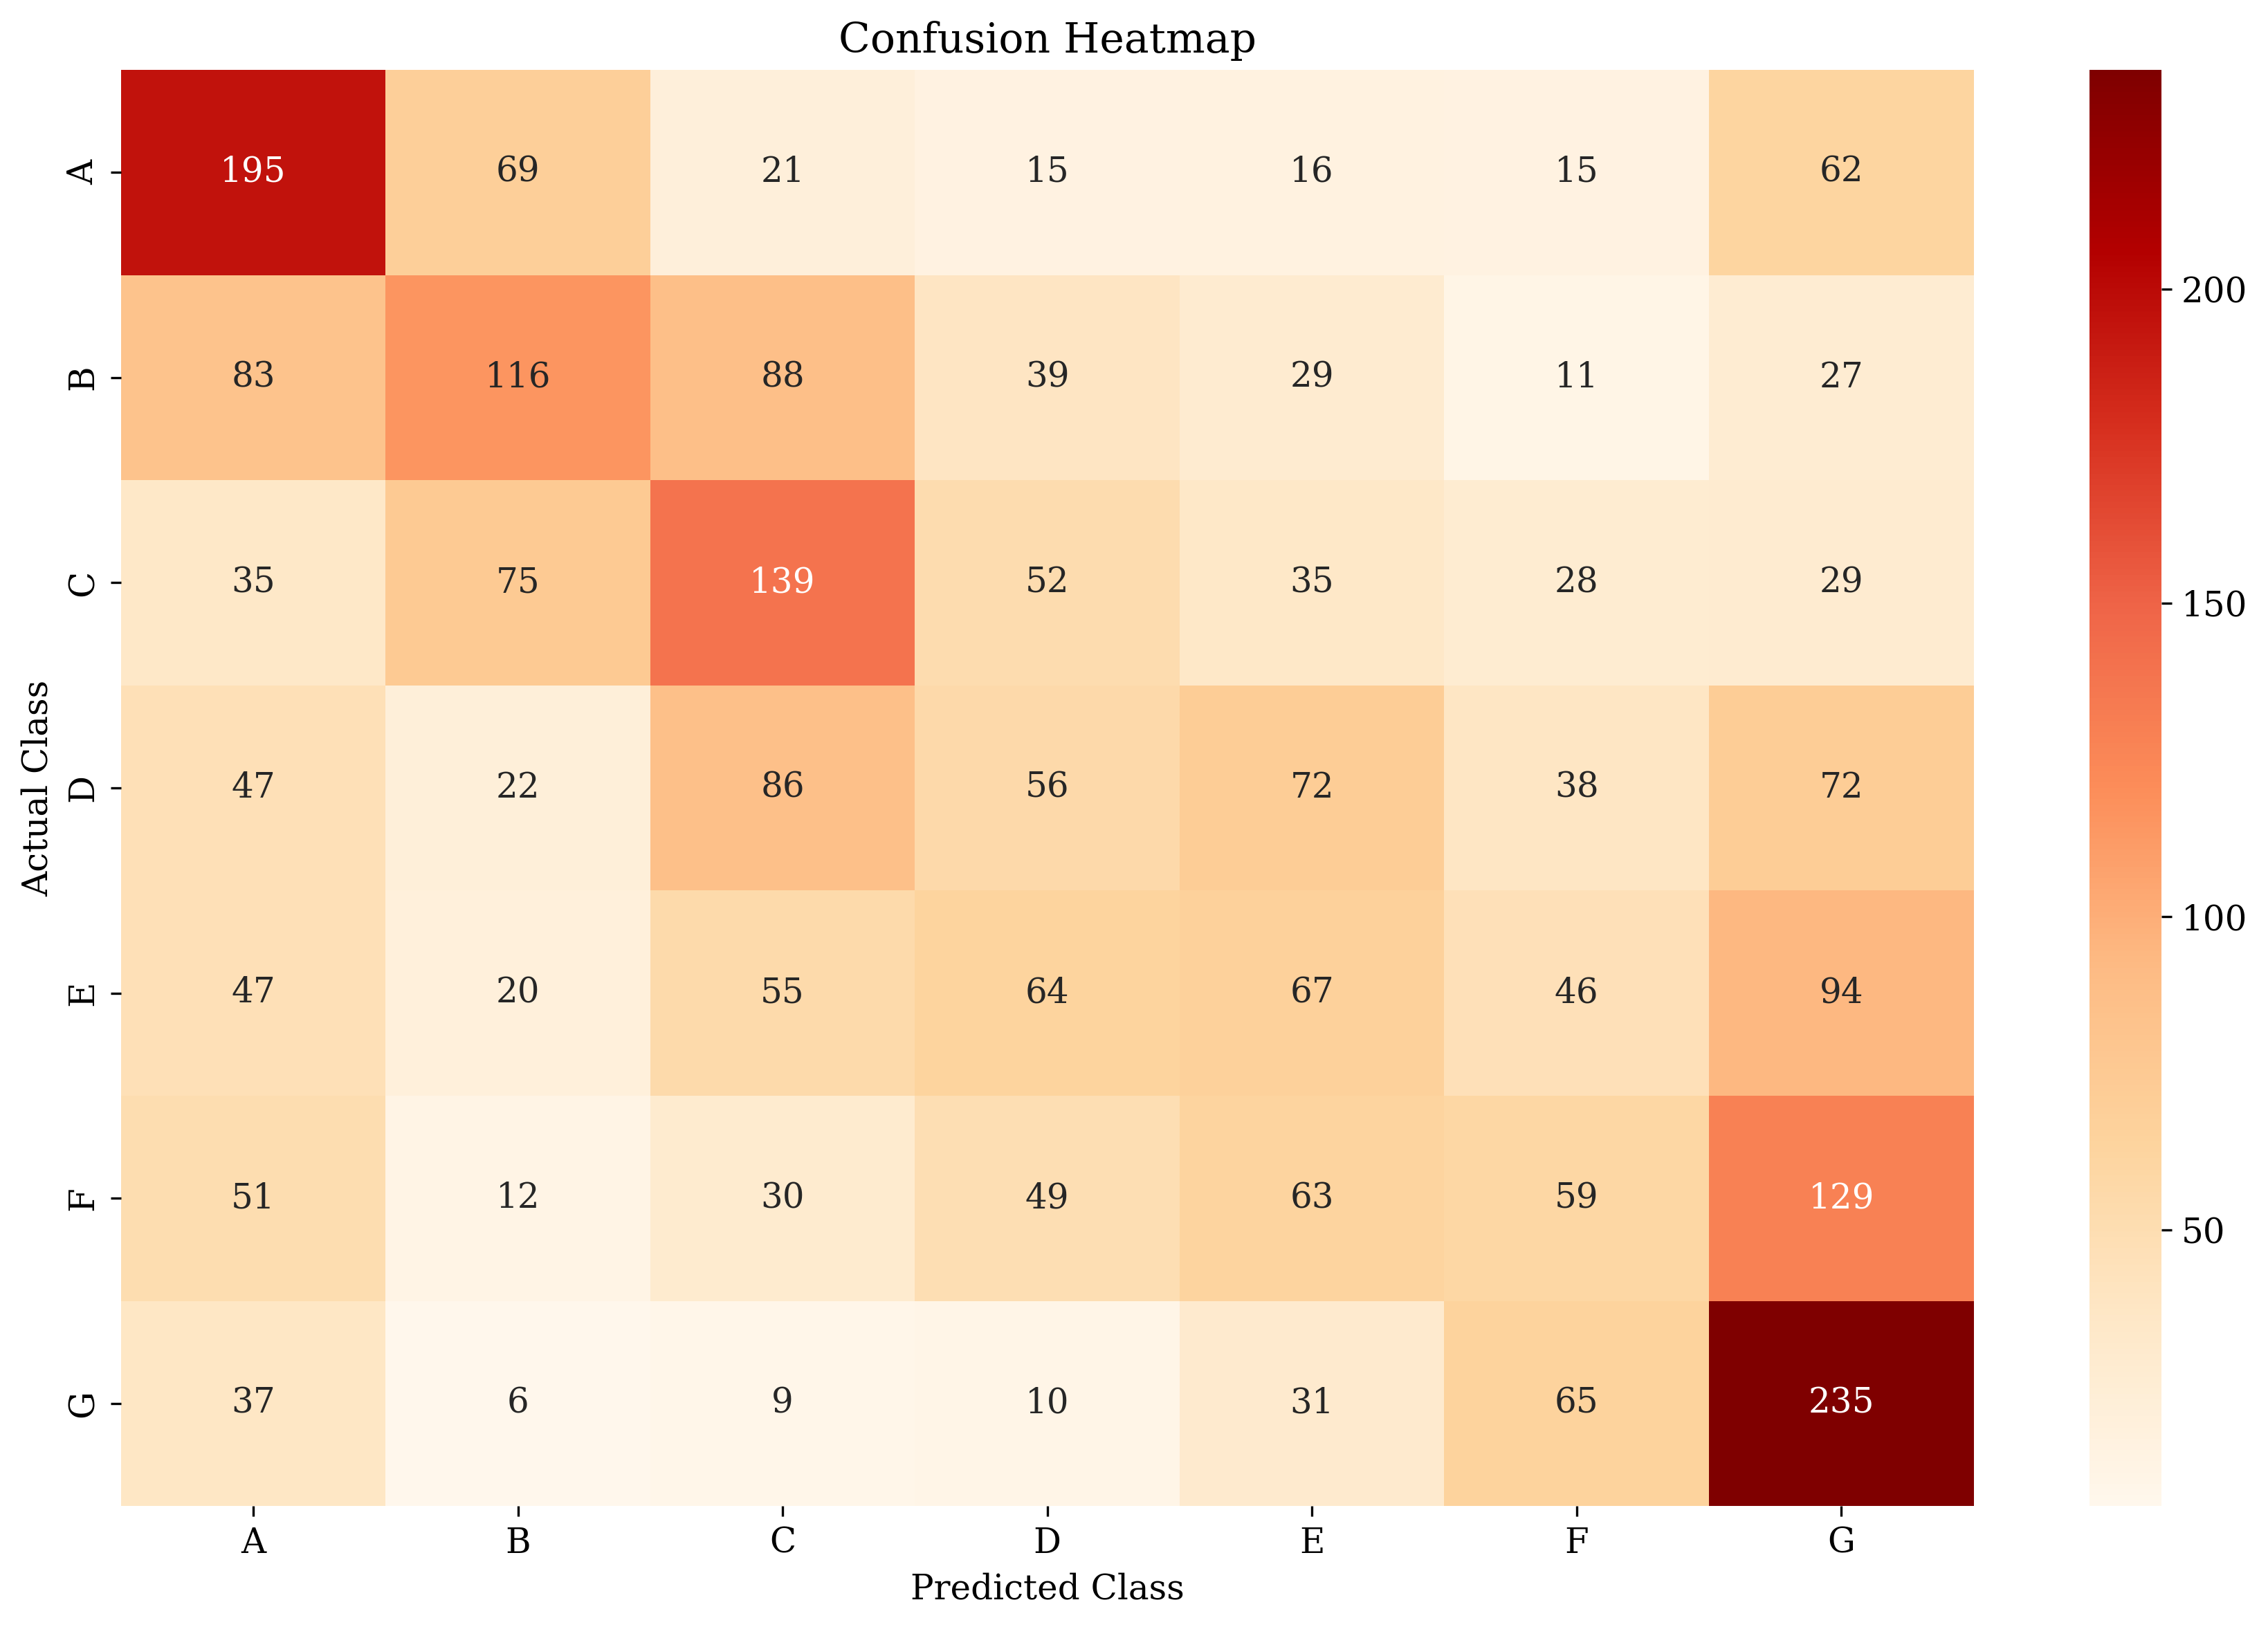

              precision    recall  f1-score   support

           A       0.39      0.50      0.44       393
           B       0.36      0.30      0.33       393
           C       0.32      0.35      0.34       393
           D       0.20      0.14      0.17       393
           E       0.21      0.17      0.19       393
           F       0.23      0.15      0.18       393
           G       0.36      0.60      0.45       393

    accuracy                           0.32      2751
   macro avg       0.30      0.32      0.30      2751
weighted avg       0.30      0.32      0.30      2751



In [102]:
model_utils.PlotConfusionMatrix(fittedgrid, X_test, y_test)

Despite running a grid search, we see that the performance of the model was not improved, achieving an accuracy of 0.32 and similar f1 scores for the classes. We can save this model, in case we want to use it at a later stage in our project.

---
<a id='save'></a>
#### Saving the model

In [103]:
import pickle

# pickle.dump(fittedgrid, open('models/logreg_model.pkl', 'wb'))

<a id='load'></a>
#### Loading the model

In [ ]:
fittedgrid = pickle.load(open('models/logreg_model.pkl', 'rb'))

---
<a id='conc'></a>
## Remarks on Logistic Regression

Overall, our logistic regression models were unable to accurately classify fires. This is probably because, as with linear regression, logistic regression is a linear model that will not perform well when the features are not linearly correlated. We have been able to see however, that a classification task is a more achievable goal in comparison to a regression task, and we can attempt to build further models, such as a decision tree classifier and even use ensemble methods to create a better performing model.